# Data Science Workshop

# Data Loading

## Import Python Libraries

Missing data by column (total rows 12773):
feed_avg_with_tagged_per_post_with_more_than_zero           12505
feed_avg_people_tagged_per_post_with_more_than_zero         12031
feed_std_shares                                             11708
general_info                                                11504
self_feed_avg_with_tagged_per_post_with_more_than_zero      10936
founded                                                     10892
feed_avg_shares                                             10603
feed_max_shares                                             10603
feed_min_shares                                             10603
price_range                                                  9660
feed_avg_people_tagged_per_post                              8470
feed_number_of_days_between_first_and_last_posts             8470
feed_avg_with_tagged_per_post                                8470
feed_post_max_people_tagged                                  8470
feed_post_max_with_tagged        

/Users/guysalama/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Initial data removal (2*stdv) - 515 samples removed, 10973 samples left
4-Bin Details:
4_bin_labels       
BIN_0         count       2,618.00
              mean        3,954.09
              std         2,573.63
              min           439.00
              25%         1,647.50
              50%         3,520.00
              75%         5,988.50
              max         9,187.00
BIN_1         count       2,865.00
              mean       20,769.61
              std         8,189.33
              min         9,194.00
              25%        13,495.00
              50%        19,553.00
              75%        27,427.00
              max        38,098.00
BIN_2         count       2,864.00
              mean       86,236.33
              std        37,889.25
              min        38,114.00
              25%        53,184.25
              50%        76,610.50
              75%       113,986.50
              max       172,395.00
BIN_3         count       2,626.00
              mean

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.3s finished


Best estimator found by grid search:
LogisticRegression(C=0.21544346900318845, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
training logistic regression
getting logistic regression predictions (bin num 0)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.7s finished


Best estimator found by grid search:
LogisticRegression(C=46.415888336127821, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
training logistic regression
getting logistic regression predictions (bin num 1)
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.5s finished


Best estimator found by grid search:
LogisticRegression(C=0.0059948425031894088, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
training logistic regression
getting logistic regression predictions (bin num 2)


Mean squared error: 1.13
training variance score: 0.72
test variance score: 0.69


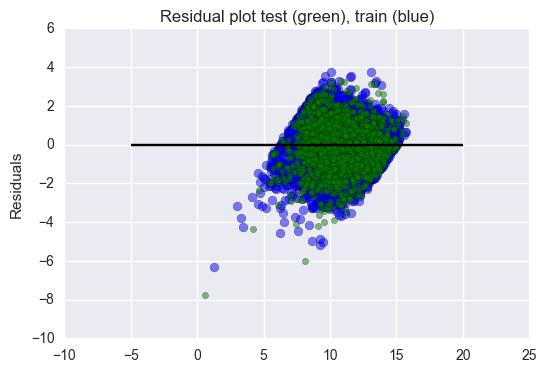

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import sklearn.linear_model as lm
from sklearn import metrics, preprocessing, svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from outliers import smirnov_grubbs as grubbs

import random

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

## Reading the Income Classification Dataset

# read the entire file into a python array
with open('new_raw_data.json', 'rb') as f:
    data = f.readlines()
with open('photos.json', 'rb') as f:
    photos_data = f.readlines()
with open('not_self_feeds.json', 'rb') as f:
    feeds_data = f.readlines()
with open('self_feeds.json', 'rb') as f:
    posts_data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
photos_data = map(lambda x: x.rstrip(), photos_data)
feeds_data = map(lambda x: x.rstrip(), feeds_data)
posts_data = map(lambda x: x.rstrip(), posts_data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"
photos_data_json_str = "[" + ','.join(photos_data) + "]"
feeds_data_json_str = "[" + ','.join(feeds_data) + "]"
posts_data_json_str = "[" + ','.join(posts_data) + "]"

# now, load it into pandas
raw_data = pd.read_json(data_json_str)
photos_raw_data = pd.read_json(photos_data_json_str)
feeds_raw_data = pd.read_json(feeds_data_json_str)
posts_raw_data = pd.read_json(posts_data_json_str)

# join all data frames - used inner join to get rid of outdated pages (pages that got deleted between our queries)
raw_data = pd.merge(left=raw_data, right=photos_raw_data, how='inner', left_on='id', right_on='page_id')
raw_data = pd.merge(left=raw_data, right=posts_raw_data, how='inner', left_on='id', right_on='page_id')
# most pages didnt have any posts from other users/pages on their feed, so left join is used here
raw_data = pd.merge(left=raw_data, right=feeds_raw_data, how='left', left_on='id', right_on='page_id')

raw_data.drop(['page_id_x', 'page_id_y', 'page_id'], axis=1, inplace=True)

# read the entire file into a python array
# with open('feeds.json', 'rb') as f:
#     data = f.readlines()
# data = map(lambda x: x.rstrip(), data)
# data_json_str = "[" + ','.join(data) + "]"
# raw_data = pd.read_json(data_json_str)


# Data preparation

ready_feats = [ 'has_cover_photo', 'has_profile_photo', 'id', 'likes', 'has_bio', 'has_birthday', 'has_company_overview',
                'has_about', 'has_hours', 'checkins', 'has_payment_options', 'search_category', 'has_mission', 'category',
#                 'category_list_len'
               
                # photo fields
                'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 'photo_avg_likes_per_photo',
                'photo_avg_people_tagged_per_photo', 'photo_avg_people_tagged_per_photo_with_more_than_zero', 
                'photo_count_has_name', 'photo_count_has_place', 'photo_distinct_uploaders', 
                'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 'photo_number_of_albums', 
                'photo_number_of_cover_albums', 'photo_number_of_different_months_for_photos', 'photo_number_of_null_albums', 
                'photo_number_of_other_albums', 'photo_number_of_photos_in_cover_albums', 'photo_number_of_photos_in_null_albums', 
                'photo_number_of_photos_in_other_albums', 'photo_number_of_photos_in_profile_albums', 
                'photo_number_of_profile_albums', 'total_photos', 'photo_number_of_days_between_first_and_last_photos',
               
                # feed fields
                'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
                'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_number_of_days_between_first_and_last_posts',
                'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_count_has_place', 
                'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
                'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
                'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
                'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                'feed_post_updated_prc', 'feed_std_comments', 'feed_std_likes', 'feed_sum_people_tagged_count', 
                'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares', 'feed_std_shares',
                'feed_distinct_post_writers', 'feed_post_count',

                # posts fields
                'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_likes_per_comment',                           
                'self_feed_avg_people_tagged_per_post', 'self_feed_avg_people_tagged_per_post_with_more_than_zero',  
                'self_feed_number_of_days_between_first_and_last_posts', 'self_feed_avg_with_tagged_per_post',                        
                'self_feed_avg_with_tagged_per_post_with_more_than_zero', 'self_feed_count_has_place',                                 
                'self_feed_count_post_updated', 'self_feed_is_published_count', 'self_feed_max_comments',
                'self_feed_max_likes', 'self_feed_min_comments', 'self_feed_min_likes', 'self_feed_number_of_added_photos_category',                 
                'self_feed_number_of_different_months_for_post', 'self_feed_number_of_null_category', 'self_feed_number_of_other_categories',                      
                'self_feed_number_of_shared_story_category', 'self_feed_post_max_people_tagged', 'self_feed_post_max_with_tagged',                            
                'self_feed_post_updated_prc', 'self_feed_std_comments', 'self_feed_std_likes', 'self_feed_sum_people_tagged_count',                         
                'self_feed_sum_with_tagged_count', 'self_feed_avg_shares', 'self_feed_max_shares', 'self_feed_min_shares',                                      
                'self_feed_std_shares', 'self_post_count'
              ]

all_data = raw_data[ready_feats].copy()

# merge identical columns
all_data['general_info'] = pd.concat([raw_data['generalInfo'].dropna(), raw_data['general_info'].dropna()]).reindex_like(raw_data)
all_data['is_permanently_closed'] = pd.concat([raw_data['isPermanentlyClosed'].dropna(), raw_data['is_permanently_closed'].dropna()]).reindex_like(raw_data)
all_data['is_unclaimed'] = pd.concat([raw_data['isUnclaimed'].dropna(), raw_data['is_unclaimed'].dropna()]).reindex_like(raw_data)
all_data['is_verified'] = pd.concat([raw_data['isVerified'].dropna(), raw_data['is_verified'].dropna()]).reindex_like(raw_data)
all_data['price_range'] = pd.concat([raw_data['priceRange'].dropna(), raw_data['price_range'].dropna()]).reindex_like(raw_data)
all_data['start_info'] = pd.concat([raw_data['startInfo'].dropna(), raw_data['start_info'].dropna()]).reindex_like(raw_data)
all_data['talking_about_count'] = pd.concat([raw_data['talkingAboutCount'].dropna(), raw_data['talking_about_count'].dropna()]).reindex_like(raw_data)
all_data['were_here_count'] = pd.concat([raw_data['wereHereCount'].dropna(), raw_data['were_here_count'].dropna()]).reindex_like(raw_data)

# create 'has' columns
all_data['has_email'] = raw_data['emails'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_phone'] = raw_data['phone'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_website'] = raw_data['website'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_location'] = raw_data['location'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_description'] = raw_data['description'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_general_info'] = all_data['general_info'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_products'] = raw_data['products'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['self_feed_has_unpublished'] = all_data[['self_post_count','self_feed_is_published_count']].apply(lambda x: x['self_post_count'] == x['self_feed_is_published_count'], 1)

# create 'num of words' columns
all_data['name_num_of_words'] = raw_data['name'].apply(lambda x: len(x.split()) if type(x) != np.float else np.nan)

# parse complex vars
all_data['location_city'] = raw_data['location'].apply(lambda x: x['city'] if (type(x) != np.float and 'city' in x) else np.nan)
all_data['location_city'].fillna(raw_data['hometown'], inplace=True)
all_data['location_country'] = raw_data['location'].apply(lambda x: x['country'] if (type(x) != np.float and 'country' in x) else np.nan)
all_data['start_info'] = all_data['start_info'].apply(lambda x: x['date']['year'] if (type(x) != np.float and 'date' in x and 'year' in x['date']) else np.nan)
all_data['price_range'] = all_data['price_range'].apply(lambda x: len(x) if type(x) != np.float else np.nan)

category_mapping = {'Bank': 'business', 'Bar': 'life_style', 'Beauty': 'life_style', 'Beverages': 'food', 'Book': 'entertainment', 'Business': 'business', 'Character': 'entertainment', 'Church': 'organization', 'Coffee': 'life_style', 'Company': 'business', 'Equipment': 'industrial', 'Event': 'organization', 'Financial': 'business', 'Foo': 'food', 'Food': 'food', 'Goods': 'life_style', 'Government': 'organization', 'Health': 'life_style', 'Materials': 'industrial', 'Movie': 'entertainment', 'Music': 'entertainment', 'Organization': 'organization', 'Pet': 'life_style', 'Political': 'organization', 'Public': 'organization', 'School': 'organization', 'Services': 'business', 'Sports': 'entertainment', 'Supplies': 'industrial', 'TV': 'entertainment', 'Team': 'entertainment', 'Venue': 'organization', 'Video': 'entertainment'}        
all_data['main_category'] = all_data['search_category'].map(category_mapping)

# frequency related features - move to feature eng
all_data['photo_upload_freq'] = all_data.apply(lambda x: x['photo_number_of_days_between_first_and_last_photos']/x['total_photos'] if x['photo_number_of_days_between_first_and_last_photos'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
all_data['feed_update_freq'] = all_data.apply(lambda x: x['feed_number_of_days_between_first_and_last_posts']/x['feed_post_count'] if x['feed_number_of_days_between_first_and_last_posts'] != np.nan and x['feed_post_count'] != np.nan else 0, axis=1)
all_data['posting_freq'] = all_data.apply(lambda x: x['self_feed_number_of_days_between_first_and_last_posts']/x['self_post_count'] if x['self_feed_number_of_days_between_first_and_last_posts'] != np.nan and x['self_post_count'] != np.nan else 0, axis=1)

# convert types
all_data['founded'] = raw_data['founded'].apply(lambda x: np.int64(x) if (type(x) == unicode and x.strip().isdigit()) else np.nan)

# drop duplicate pages (we got some pages twice because we queried by page category and some pages were in several categrories)
all_data.drop_duplicates(subset='id', keep='last', inplace=True)

## Missing Data Imputation

print "Missing data by column (total rows %s):" % all_data.id.count()
missing_count = all_data.isnull().sum().sort_values(ascending=False)
print missing_count[missing_count.nonzero()[0]]

# drop features too sparse or that have no meaningful way to fill
feats_to_drop = ['founded', 'start_info', 'general_info', 'feed_avg_with_tagged_per_post_with_more_than_zero', 
                 'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_std_shares', 
                 'self_feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_post_updated_prc']
all_data.drop(feats_to_drop, axis = 1, inplace=True)

# NaN to 0
numeric_impute = [  'photo_avg_people_tagged_per_photo_with_more_than_zero', 'price_range',
                  
                    'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
                    'feed_number_of_days_between_first_and_last_posts',
                    'feed_avg_with_tagged_per_post', 'feed_count_has_place', 
                    'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
                    'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
                    'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
                    'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                    'feed_std_comments', 'feed_std_likes', 
                    'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares',
                    'feed_distinct_post_writers', 'feed_post_count', 'feed_update_freq', 'feed_sum_people_tagged_count',
                    
                    'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_people_tagged_per_post', 
                    'self_feed_avg_people_tagged_per_post_with_more_than_zero', 'self_feed_number_of_days_between_first_and_last_posts', 
                    'self_feed_avg_with_tagged_per_post', 'self_feed_max_comments', 
                    'self_feed_max_likes', 'self_feed_min_comments', 'self_feed_min_likes', 'self_feed_post_max_people_tagged', 
                    'self_feed_post_max_with_tagged', 'self_feed_std_comments', 'self_feed_std_likes',  
                    'self_feed_avg_shares', 'self_feed_max_shares', 'self_feed_min_shares', 
                    'self_feed_std_shares', 'posting_freq', 'self_feed_sum_people_tagged_count', 'self_feed_sum_with_tagged_count'
                 ]
all_data[numeric_impute] = all_data[numeric_impute].fillna(0) 

# fill missing countries by city
all_data['location_country'].fillna('empty', inplace=True)
all_data['location_city'].fillna('empty', inplace=True)
temp = {k: g["location_country"].tolist() for k,g in all_data.groupby("location_city")}
city_to_country = {}
for city, countries in temp.items():
    if city == 'empty':
        city_to_country[city] = 'empty'
        continue
    for country in countries:
        if country != 'empty':
            city_to_country[city] = country
            break
    if city_to_country.get(city) is None:
        city_to_country[city] = 'empty'
all_data['location_country'] = all_data.apply(lambda x: x['location_country'] if x['location_country'] != 'empty' else city_to_country[x['location_city']], axis=1)
all_data['location_country'].fillna('empty', inplace=True)
val_count = all_data['location_country'].value_counts()
all_data['country'] = all_data.location_country.apply(lambda x: x if val_count[x] > 150 else 'other')
all_data.drop(['location_city', 'location_country'], axis = 1, inplace=True)

continent_mapping = {'United States': 'America', 'Thailand': 'Asia', 'Australia': 'Australia', 'Bangladesh': 'Asia', 'Brazil': 'America', 'Cambodia': 'Asia', 'Egypt': 'Africa', 'India': 'Asia', 'Israel': 'Asia', 'Mexico': 'America', 'Myanmar': 'Africa', 'Pakistan': 'Asia', 'Philippines': 'Asia', 'South Africa': 'Africa', 'United Kingdom': 'Europe', 'Vietnam': 'Asia', 'empty': 'Global', 'other': 'Europe'}
all_data['continent'] = all_data.country.map(continent_mapping)

print "Columns with missing data: ", all_data.isnull().sum().nonzero()[0]

## Types Conversion

binary_variables = ['has_email', 'has_phone', 'has_website', 'has_location', 
                    'is_permanently_closed', 'is_unclaimed', 'is_verified', 'has_description', 
                    'has_general_info', 'has_products', 'self_feed_has_unpublished']

for variable in binary_variables:
    all_data[variable] = all_data[variable].astype(int)
    
for feat in all_data.columns.get_values():
    print "%s\t%s\t%s" % (all_data.columns.get_loc(feat), all_data.dtypes[all_data.columns.get_loc(feat)], feat)

# Data Cleaning

def get_features_to_analyze():
    features = all_data.columns.get_values().tolist()
    features_to_remove = ['likes', 'country', 'search_category', 'category', 'main_category', 'continent']
    return [a for a in features if a not in features_to_remove]

### Remove features with low std

features = get_features_to_analyze()
stds = {}

for feat in features:
    curr_std = all_data[feat].std()
    stds[feat] = curr_std
    
sorted_by_std = sorted(stds.items(), key=lambda x: x[1])
low_std = [a for a in sorted_by_std if a[1] < 0.3]
for a in low_std:
    print a[0] + " -- with std of: " + str(a[1])

zero_std_features = [a[0] for a in sorted_by_std if a[1] == 0]

# remove permanently_closed and is_unclaimed pages
all_data = all_data[all_data['is_permanently_closed'] != 1].reset_index(drop=True)
all_data = all_data[all_data['is_unclaimed'] != 1].reset_index(drop=True)
low_std_features = zero_std_features + ['is_permanently_closed', 'is_unclaimed', 'feed_number_of_null_category']

# drop features with low std
all_data.drop(low_std_features, axis=1, inplace=True)

### Remove too correlated features

features = get_features_to_analyze()

corrs = {}
threshold = 0.9

for i in range(len(features)):
    for j in range(i+1,len(features)):
        curr_corr = np.corrcoef(all_data[features[i]], all_data[features[j]])
        c = curr_corr[0][1]
        if c > threshold or c < -(threshold):
            corrs[(features[i],features[j])] = c
            
sorted_by_corr = sorted(corrs.items(), key=lambda x: x[1], reverse=True)
for a in sorted_by_corr:
        print a[0][0] + " and " + a[0][1] + " -- with correlation of: " + str(a[1])

        

all_data['self_feed_has_unpublished'] = all_data.apply(lambda x: x['self_post_count'] != x['self_feed_is_published_count'], 1)


# drop features too correlated
too_coor_feats = ['feed_is_published_count', 'self_feed_is_published_count', 'feed_distinct_post_writers',
                  'photo_number_of_photos_in_other_albums', 
                  'self_feed_sum_with_tagged_count', 'self_feed_sum_people_tagged_count',
                  'feed_sum_people_tagged_count', 'feed_sum_with_tagged_count']
all_data.drop(too_coor_feats, axis=1, inplace=True)

## Manual data normalization

normal_by_total_count_vars = [  ['photo_number_of_cover_albums', 'photo_number_of_albums'],
                                ['photo_number_of_other_albums', 'photo_number_of_albums'],
                                ['photo_number_of_profile_albums', 'photo_number_of_albums'],
                                ['photo_number_of_photos_in_cover_albums', 'total_photos'],
                                ['photo_number_of_photos_in_profile_albums', 'total_photos'],
                                ['photo_count_has_name', 'total_photos'],
                                ['photo_count_has_place', 'total_photos'],
                                ['feed_count_has_place', 'feed_post_count'],
                                ['feed_count_post_updated', 'feed_post_count'],
                                ['feed_number_of_added_photos_category', 'feed_post_count'],
                                ['feed_number_of_different_months_for_post', 'feed_post_count'],
                                ['feed_number_of_other_categories', 'feed_post_count'],
                                ['feed_number_of_shared_story_category', 'feed_post_count'],
                                ['self_feed_count_has_place', 'self_post_count'],
                                ['self_feed_count_post_updated', 'self_post_count'],
                                ['self_feed_number_of_added_photos_category', 'self_post_count'],
                                ['self_feed_number_of_different_months_for_post', 'self_post_count'],
                                ['self_feed_number_of_null_category', 'self_post_count'],
                                ['self_feed_number_of_other_categories', 'self_post_count'],
                                ['self_feed_number_of_shared_story_category', 'self_post_count']
                             ]

for feat in normal_by_total_count_vars: 
    all_data[feat[0]] = all_data.apply(lambda x: (x[feat[0]] / x[feat[1]]) if (x[feat[1]] != 0) else 0, axis=1)
    
# originally the api calls to facebook were supposed to get the first 150 photos/feed posts of a page.
# along the way we got a little more in some cases, so after normalization of the relevant features by this count, 
# we lower them to 150 to prevent bias..
all_data['total_photos'] = all_data['total_photos'].apply(lambda x: x if x <= 150 else 150)
all_data['feed_post_count'] = all_data['feed_post_count'].apply(lambda x: x if x <= 150 else 150)
all_data['self_post_count'] = all_data['self_post_count'].apply(lambda x: x if x <= 150 else 150)

# Models

## Utils

def binning(col,bin_num, labels=None):
    if labels is None:
        labels = ['BIN_'+str(i) for i in range(bin_num)]

    colBin = pd.qcut(col,bin_num,labels=labels)
    return colBin

def plot_results(x, y, tag, arg):
    plt.plot(x, y)
    plt.title(tag + " as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel(tag)
    plt.show()

def plot_cross_val(cs, cv_scores, arg):
    plt.plot(cs, cv_scores)
    plt.title("Average Precision as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel("Precision")
    ax = plt.axes()
    ax.set_xscale('log')
    plt.show()

def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()

def plotMetrics(expected,predicted):
    y_true = expected
    y_score = predicted
    #y_score = df['rawPrediction'].map(lambda x: x['values'][1])
    auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    plotRoc(fpr, tpr, auc)
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
    plotPR(precision, recall)

def plotConfusion(matrix, n, model_name=''):
    plt.title(model_name + ' Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.imshow(np.reshape(matrix, (n, n)), interpolation='nearest', cmap="hot")
    plt.colorbar()
    plt.show()
    
def print_ds_fields(ds):
    for feat in ds.columns.get_values():
        print "%s\t%s\t%s" % (ds.columns.get_loc(feat), ds.dtypes[ds.columns.get_loc(feat)], feat)
        
def _log(x):
    if x > 0:
        return np.log(x)
    return x  

def remove_outliers(ds, feat, stdv_cut):
    if feat == 'likes':
        ds['log_' + feat] = ds[feat].apply(_log)
        ds = ds[abs(ds['log_' + feat] - ds['log_' + feat].mean()) <= stdv_cut*ds['log_' + feat].std()]
        ds.drop('log_' + feat, 1, inplace=True)
    else:
        ds = ds[abs(ds[feat] - ds[feat].mean()) <= stdv_cut*ds[feat].std()]
    return ds

def prepare_data(data_set, label_limit, bins=4, ids=False):
    from sklearn.utils import shuffle
    
    data_set = shuffle(data_set.copy())
    if type(label_limit) is int:
        labels = data_set['likes'].apply(lambda x: 0 if x <= label_limit else 1)
        seperators = []
    elif label_limit == 'bins':
        labels = binning(data_set['likes'], bins)
    
    train_len = int(len(data_set.id) * 0.8)

    train_ids = data_set['id'][:train_len].copy()
    test_ids = data_set['id'][train_len:].copy()

    data_set.drop(['likes', 'id', 'labels'], 1, inplace=True, errors='ignore')
    
    train_set = data_set[:train_len].copy()
    train_labels = labels[:train_len].copy()
    test_set = data_set[train_len:].copy()
    test_labels = labels[train_len:].copy()

    if ids:
        return train_set, test_set, train_labels, test_labels, train_ids, test_ids
    return train_set, test_set, train_labels, test_labels

def get_feat_sel(train_set, test_set, train_labels, test_labels, model, bins=4,  min_feats=30, verbose=False): #scoring='roc_auc', 
    all_feats = train_set.columns.values.tolist()
    numerical_feats = [feat for feat in all_feats if set(train_set[feat].unique()) != {-1,1} and feat not in ['id']]

    # feature selection
    results = []
    feats_num = train_set.shape[1]
    threshold = 0.001
    while feats_num > min_feats:
        model.fit(train_set, train_labels)
        sfm = SelectFromModel(model, prefit=True, threshold=threshold)
        if len(sfm.get_support(indices=True)) == feats_num:
            threshold = threshold*10
        else:
            feats_num = len(sfm.get_support(indices=True))
            threshold = threshold*1.5

        if feats_num <= train_set.shape[1] * 0.8:
            if verbose: print "get_data_sets: found threshold %s that selected %s feats" % (threshold, feats_num)

            new_train_set = sfm.transform(train_set)
            new_test_set = sfm.transform(test_set)
            # re-fit model to score new data set
            model.fit(new_train_set, train_labels)
            result = {
                'feats_num': feats_num,
                'threshold': threshold,
                'selected_idx': list(sfm.get_support(indices=True)),
                'selected_feats': [all_feats[i] for i in sfm.get_support(indices=True)],
                'val_score': model.score(new_test_set, test_labels),
                'train_score': model.score(new_train_set, train_labels),
            }
            results.append(result)
    
    return sorted(results, key=lambda x: x['val_score'], reverse=True)

def bins_to_binary(labels, sel_bin, is_1_vs_all=False):
    if is_1_vs_all:
        result = labels.apply(lambda x: x == sel_bin)
    else:
        result = labels.apply(lambda x: int(x[-1]) <= int(sel_bin[-1]))
    return result

def get_data_sets_from_disk(prefix):
    import os
    import json
    import pickle
    
    files = ['data_sets\\' + filename for filename in os.listdir('data_sets') if filename.startswith(prefix)]
    
    data_sets = []
    for file_name in files:
        with open(file_name, 'r') as f:
            obj = json.loads(f.read())
            obj['data_sets'] = (pickle.loads(obj['data_sets'][0]), pickle.loads(obj['data_sets'][1]), pickle.loads(obj['data_sets'][2]), pickle.loads(obj['data_sets'][3]))
            data_sets.append(obj)
    
    return data_sets

def eval_model(model_name, labels, predictions, predicted_probs, is_test=False, bin_num=8):
    data_type = "test" if is_test else "train"
    print str.upper(model_name + " " + data_type + " results")
    print "=========" + "=" * len(model_name + data_type)
    print "calculating " + model_name + " Performance on the " + data_type + " set:"
    
    print "\nclassification report:"
    print(metrics.classification_report(labels, predictions))
    
    if (bin_num == 2):
        plotMetrics(labels,predicted_probs)
        fpr, tpr, thresholds = metrics.roc_curve(labels, predicted_probs)
        auc = metrics.auc(fpr, tpr)
        print model_name + " " + data_type + " set auc:", auc
        plotRoc(fpr, tpr, auc)
    
    print "\nconfusion matrix with " + str(bin_num) + " bins: "
    cm = confusion_matrix(labels.values, predictions)
    print cm
    plotConfusion(cm, bin_num, model_name)
    
def grubbs_outlier_removal(data_set, feats, verbose=False):
    ds = data_set.copy()
    total_diff = 0
    for feat in feats:
        temp = ds.shape[0]
        idxs = grubbs.two_sided_test_indices(ds[feat], alpha=0.05)
        ds.drop(ds.index[idxs], inplace=True)
        if verbose: print "grubbs_outlier_removal: feat %s - %s samples removed, %s samples left" % (feat, len(idxs), ds.shape[0])
        total_diff += temp - ds.shape[0]

    if verbose: print "grubbs_outlier_removal: Total of %s samples removed, %s samples left" % (total_diff, ds.shape[0])
    return ds


## General Preprocessing

### dummies variables 

# change back empty and 0 to NaN before converting to dummy variables
categorical_variables = ['country', 'price_range', 'main_category', 'search_category', 'category', 'continent']
filtered_all_data = all_data.copy()
# country_dv = pd.get_dummies(filtered_all_data['country'].apply(lambda x: x if x != 'empty' else np.nan), prefix='country')
price_dv = pd.get_dummies(filtered_all_data['price_range'].apply(lambda x: x if x > 0 else np.nan), prefix='price_range')
category_dv = pd.get_dummies(filtered_all_data['main_category'], prefix='main_category')
continent_dv = pd.get_dummies(filtered_all_data['continent'], prefix='continent')

print "shape before dummy vars: ", filtered_all_data.shape
pp_data = pd.concat([filtered_all_data, price_dv, category_dv, continent_dv], axis=1)
pp_data.drop(categorical_variables, 1, inplace=True)
print "shape after dummy vars: ", pp_data.shape

### Data Normalization - run log on numerical features and scale

cat_vars = [feat for feat in pp_data.columns.values.tolist() if set(pp_data[feat].unique()) == {0,1}]
pp_data[cat_vars] = pp_data[cat_vars].astype(bool)
for feat in cat_vars:
    pp_data[feat] = pp_data[feat].apply(lambda x: 1 if x else -1)
    
exp_feats = [feat for feat in pp_data.columns.get_values().tolist() if set(pp_data[feat].unique()) != {-1,1} and feat not in ['id', 'name_num_of_words', 'likes', 'labels']]
for feat in exp_feats:
    pp_data[feat] = pp_data[feat].apply(_log)
    max_val = pp_data[feat].max()
    pp_data[feat] = preprocessing.scale(pp_data[feat].apply(lambda x: -max_val if x == 0 else x))
    

### Split data to test and train/validation sets

from sklearn.utils import shuffle

pp_data = shuffle(pp_data)
pp_data['4_bin_labels'] = binning(pp_data['likes'], 4)
pp_data['8_bin_labels'] = binning(pp_data['likes'], 8)

test_data_len = int(pp_data.shape[0] * 0.1)
test_pp_data = pp_data[:test_data_len]

test_data_ids = test_pp_data['id'].copy()
test_data_labels = test_pp_data[['likes', '4_bin_labels', '8_bin_labels']].copy()
test_data_set = test_pp_data.drop(['id', 'likes', '4_bin_labels', '8_bin_labels'], axis=1)

pp_data = pp_data[test_data_len:]

### Initial outlier removal

# all_feats = pp_data.columns.values.tolist()
# numerical_feats = [feat for feat in all_feats if set(pp_data[feat].unique()) != {-1,1} and feat not in ['id']]
# results = []

# total_diff = 0
# stdv = 5
# for feat in numerical_feats:
#     temp = pp_data.shape[0]
#     temp_data_set = remove_outliers(pp_data, feat, stdv)
#     while temp - temp_data_set.shape[0] > 100:
#         stdv += 1
#         temp_data_set = remove_outliers(pp_data, feat, stdv)
#     stdv = 5
#     pp_data = temp_data_set
#     if temp - pp_data.shape[0] > 0: 
#         print "feat %s removed %s samples" % (feat, temp - pp_data.shape[0])
#     total_diff += temp - pp_data.shape[0]

temp = pp_data.shape[0]
pp_data = pp_data[pp_data['likes'] > 0]
pp_data = remove_outliers(pp_data, 'likes', 2)

print "Initial data removal (2*stdv) - %s samples removed, %s samples left" % (temp - pp_data.shape[0], pp_data.shape[0])

### Split data set to train and validation data

train_len = int(pp_data.shape[0] * 0.8)

train_ids = pp_data['id'][:train_len].copy()
val_ids = pp_data['id'][train_len:].copy()

train_labels = pp_data[['likes', '4_bin_labels', '8_bin_labels']][:train_len].copy()
val_labels = pp_data[['likes', '4_bin_labels', '8_bin_labels']][train_len:].copy()

temp_pp_data = pp_data.drop(['likes', 'id', '4_bin_labels', '8_bin_labels'], 1, errors='ignore')
train_set = temp_pp_data[:train_len].copy()
val_set = temp_pp_data[train_len:].copy()

print "4-Bin Details:"
print pp_data.groupby('4_bin_labels')['likes'].describe()
print "8-Bin Details:"
print pp_data.groupby('8_bin_labels')['likes'].describe()

predictions_ds = pp_data['id'].copy()
test_predictions_ds = test_pp_data['id'].copy()

lr_train_set = train_set.copy()
lr_val_set = val_set.copy()

for seperator in range(3):
    lr_train_labels = bins_to_binary(train_labels['4_bin_labels'], 'BIN_%s' % seperator)
    lr_val_labels = bins_to_binary(val_labels['4_bin_labels'], 'BIN_%s' % seperator)
    
    param_grid = {'C': np.logspace(-3, 4, num=10)}
    clf = GridSearchCV(lm.LogisticRegression(), param_grid, verbose=True)
    clf = clf.fit(lr_train_set, lr_train_labels)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print "training logistic regression"
    lr = clf.best_estimator_
    lr.fit(lr_train_set, lr_train_labels)

    print "getting logistic regression predictions (bin num %s)" % seperator
    lr_predicted_probs = lr.predict_proba(np.concatenate((lr_train_set, lr_val_set)))[:, 1]
    lr_predictions = lr.predict(np.concatenate((lr_train_set, lr_val_set)))

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_set.shape[0]]
    lr_val_predicted_probs = lr_predicted_probs[lr_train_set.shape[0]:]

    lr_train_predictions = lr_predictions[:lr_train_set.shape[0]]
    lr_val_predictions = lr_predictions[lr_train_set.shape[0]:]
    
#     eval_model("LR binary prediction - BIN_%s:" % seperator, val_labels, lr_val_predictions, lr_val_predicted_probs, True, 2)
    
    # attach LR predictions to predictions_ds
    predictions_ds['lr_prediction_proba_%s' % seperator] = preprocessing.minmax_scale(lr_predicted_probs.copy(), feature_range=(-1, 1))
    test_predictions_ds['lr_prediction_proba_%s' % seperator] = preprocessing.minmax_scale(lr.predict_proba(test_data_set)[:, 1], feature_range=(-1, 1))

## Linear Regression - Numerical prediction

#### Get numerical predictions from Linear Regression to be used as a feature for the multi class models

linr_train_set = train_set.copy()
linr_val_set = val_set.copy()

linr_train_labels = train_labels['likes'].apply(_log)
linr_val_labels = val_labels['likes'].apply(_log)

linr = sklearn.linear_model.LinearRegression()
linr.fit(linr_train_set, linr_train_labels)

train_predictions = linr.predict(linr_train_set)
val_predictions = linr.predict(linr_val_set)

predictions_ds['linr_prediction'] = preprocessing.minmax_scale(np.concatenate((train_predictions, val_predictions)), feature_range=(-1, 1))
test_predictions_ds['linr_prediction'] = preprocessing.minmax_scale(linr.predict(test_data_set), feature_range=(-1, 1))

# The mean squared error
print "\n\nMean squared error: %.2f" %(np.mean((linr.predict(linr_train_set) - linr_train_labels) ** 2))
# Explained variance score: 1 is perfect prediction
print 'training variance score: %.2f' %(linr.score(linr_train_set, linr_train_labels))
print 'test variance score: %.2f' %(linr.score(linr_val_set, linr_val_labels))
plt.scatter(train_predictions, train_predictions -  linr_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(val_predictions, val_predictions -  linr_val_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=-5, xmax=20)
plt.title('Residual plot test (green), train (blue)')
plt.ylabel('Residuals')
plt.show()

### Attach new features to data sets

pp_data['lr_predict_0'] = predictions_ds['lr_prediction_proba_0'].copy()
pp_data['lr_predict_1'] = predictions_ds['lr_prediction_proba_1'].copy()
pp_data['lr_predict_2'] = predictions_ds['lr_prediction_proba_2'].copy()
pp_data['linr_predict'] = predictions_ds['linr_prediction'].copy()

test_pp_data['lr_predict_0'] = test_predictions_ds['lr_prediction_proba_0'].copy()
test_pp_data['lr_predict_1'] = test_predictions_ds['lr_prediction_proba_1'].copy()
test_pp_data['lr_predict_2'] = test_predictions_ds['lr_prediction_proba_2'].copy()
test_pp_data['linr_predict'] = test_predictions_ds['linr_prediction'].copy()

new_feats = ['lr_predict_0', 'lr_predict_1', 'lr_predict_2', 'linr_predict']
train_set[new_feats] = pp_data[new_feats][:train_len].copy()
val_set[new_feats] = pp_data[new_feats][train_len:].copy()
test_data_set[new_feats] = test_pp_data[new_feats].copy()

In [2]:
import json


# feat_sel_list = get_feat_sel(train_set, val_set, train_labels['likes'], val_labels['likes'], lm.LinearRegression(), verbose=True)
# with open('data_sets\LINR.json', 'w') as linrf:
#     linrf.write(json.dumps(feat_sel_list))

# feat_sel_list = get_feat_sel(train_set, val_set, train_labels['likes'], val_labels['likes'], lm.Lasso(), verbose=True)
# with open('data_sets\LASSO.json', 'w') as lassf:
#     lassf.write(json.dumps(feat_sel_list))

# feat_sel_list = get_feat_sel(train_set, val_set, train_labels['4_bin_labels'], val_labels['4_bin_labels'], lm.LogisticRegression(penalty='l2', C=1), verbose=True)
# with open('data_sets\LR.json', 'w') as lrf:
#     lrf.write(json.dumps(feat_sel_list))

feat_sel_list = get_feat_sel(train_set, val_set, train_labels['4_bin_labels'], val_labels['4_bin_labels'], svm.SVC(class_weight='balanced', C=10, kernel='linear'), verbose=True)
with open('data_sets\SVM.json', 'w') as svmf:
    svmf.write(json.dumps(feat_sel_list))

get_data_sets: found threshold 0.3375 that selected 92 feats
get_data_sets: found threshold 0.50625 that selected 75 feats
get_data_sets: found threshold 0.759375 that selected 49 feats
get_data_sets: found threshold 1.1390625 that selected 38 feats
get_data_sets: found threshold 1.70859375 that selected 25 feats


In [8]:
with open('data_sets\LINR.json', 'r') as linrf:
    l = json.loads(linrf.read())

In [11]:
for r in l:
    print r['test_score']
print l[0]

0.457933959129
0.457134871785
0.456209606543
0.453039736197
0.450945116255
0.442118048647
0.434070509539
0.433224961898
0.406983782152
{u'test_score': 0.4579339591293581, u'feats_num': 83, u'train_score': 0.482593749522082, u'selected_feats': [u'has_cover_photo', u'has_bio', u'has_birthday', u'has_company_overview', u'has_about', u'has_hours', u'checkins', u'has_payment_options', u'has_mission', u'photo_avg_comments_per_photo', u'photo_avg_likes_per_comments', u'photo_avg_likes_per_photo', u'photo_avg_people_tagged_per_photo', u'photo_avg_people_tagged_per_photo_with_more_than_zero', u'photo_count_has_name', u'photo_count_has_place', u'photo_max_like', u'photo_max_people_tagged', u'photo_min_like', u'photo_number_of_albums', u'photo_number_of_cover_albums', u'photo_number_of_photos_in_cover_albums', u'photo_number_of_photos_in_profile_albums', u'photo_number_of_profile_albums', u'total_photos', u'photo_number_of_days_between_first_and_last_photos', u'feed_avg_comments', u'feed_avg_like

### Test feature selection on Logistic Regression (sanity)

In [19]:
train_labels = bins_to_binary(train_labels['4_bin_labels'], 'BIN_1') 
val_labels = bins_to_binary(val_labels['4_bin_labels'], 'BIN_1') 

print "Logistic regression feature selection by importance:"
lr = lm.LogisticRegression(penalty='l2', C=0.01) #dual=True)
lr.fit(train_set, train_labels)
print "Train set score (before selection): ", lr.score(train_set, train_labels)
print "Validation set score (before selection): ", lr.score(val_set, val_labels)

sfm = SelectFromModel(lr, prefit=True, threshold=0.0005)

selected_feats = sfm.get_support(indices=True)
print "total of %s out of %s feats left:" % (len(selected_feats), len(train_set.columns.get_values()))
for feat_idx in selected_feats:
    print "%s\t%s" % (feat_idx, train_set.columns.get_values()[feat_idx])

new_train = sfm.transform(train_set)
new_test = sfm.transform(val_set)
lr.fit(new_train, train_labels)
print "Train set score (after selection): ", lr.score(new_train, train_labels)
print "Validation set score (after selection): ",  lr.score(new_test, val_labels)

Logistic regression feature selection by importance:
Train set score (before selection):  0.848300852022
Test set score (before selection):  0.846846846847
total of 128 out of 128 feats left:
0	has_cover_photo
1	has_bio
2	has_birthday
3	has_company_overview
4	has_about
5	has_hours
6	checkins
7	has_payment_options
8	has_mission
9	photo_avg_comments_per_photo
10	photo_avg_likes_per_comments
11	photo_avg_likes_per_photo
12	photo_avg_people_tagged_per_photo
13	photo_avg_people_tagged_per_photo_with_more_than_zero
14	photo_count_has_name
15	photo_count_has_place
16	photo_max_like
17	photo_max_people_tagged
18	photo_min_like
19	photo_number_of_albums
20	photo_number_of_cover_albums
21	photo_number_of_different_months_for_photos
22	photo_number_of_other_albums
23	photo_number_of_photos_in_cover_albums
24	photo_number_of_photos_in_profile_albums
25	photo_number_of_profile_albums
26	total_photos
27	photo_number_of_days_between_first_and_last_photos
28	feed_avg_comments
29	feed_avg_likes
30	feed

## Logistic Regression - Binary model

#### Get binary predictions from LR to be used as features for the multi class models

## Logistic Regression

### Generate feature selection combinations (save/load from disk to save time)

In [ ]:
# Getting feature selections from disk

# import json

# feat_sel_list = get_feat_sel(lr_train_set, lr_val_set, lr_train_labels, lr_val_labels, lm.LogisticRegression(penalty='l2', C=1), verbose=True)
# with open('data_sets\LR.json', 'w') as lrf:
#     lrf.write(json.dumps(feat_sel_list))

# feat_sel_list = get_feat_sel_from_disk("LR")
with open('data_sets\LR.json', 'r') as lrf:
    feat_sel_list = json.loads(lrf.read())

In [ ]:
scores = []

for feat_sel in feat_sel_list:
    lr_train_set, lr_val_set, lr_train_labels, lr_val_labels = ds_result['data_sets']

    print("Fitting the classifier to the training set %s# (out of %s)" % (data_sets.index(ds_result) + 1, len(data_sets)))
    param_grid = {'C': np.logspace(-3,2, num=6)}
    clf = GridSearchCV(lm.LogisticRegression(penalty='l2'), param_grid, verbose=True)
    clf = clf.fit(lr_train_set, lr_train_labels)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print "training logistic regression"
    lr = clf.best_estimator_

    lr.fit(lr_train_set, lr_train_labels)
    print "getting logistic regression predictions"
    lr_predicted_probs = lr.predict_proba(lr_train_set.append(lr_val_set, ignore_index=True))[:, 1]
    lr_predictions = lr.predict(lr_train_set.append(lr_val_set, ignore_index=True))

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_set.shape[0]]
    lr_val_predicted_probs = lr_predicted_probs[lr_train_set.shape[0]:]

    lr_train_predictions = lr_predictions[:lr_train_set.shape[0]]
    lr_val_predictions = lr_predictions[lr_train_set.shape[0]:]
    
    score = {
        'train_1': metrics.precision_score(lr_train_labels, lr_train_predictions, average='macro'),
        'train_2': metrics.precision_score(lr_train_labels, lr_train_predictions, average='micro'),
        'val_1': metrics.precision_score(lr_val_labels, lr_val_predictions, average='macro'),
        'val_2': metrics.precision_score(lr_val_labels, lr_val_predictions, average='micro'),
        'data_set_obj': ds_result
    }
#     print "========="
#     print "ALL DATA:"
#     print "========="
    m = confusion_matrix(lr_train_labels, lr_train_predictions)
#     print m
#     plotConfusion(m, 4)
    score['all_m'] = m
    
#     print "=============="
#     print "TEST SET ONLY:"
#     print "=============="
    m = confusion_matrix(lr_val_labels, lr_val_predictions)
#     print m
#     plotConfusion(m, 4)
    score['val_m'] = m
    
#     print "train score:", score['train_1']
#     print "train score:", score['train_2']
#     # print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='samples')
#     print "test score:", score['val_1']
#     print "test score:", score['val_2']
#     # print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='samples')
    scores.append(score)


In [ ]:
higher_total = {'score': 0}
higher_test = {'score': 0}
for score in scores:
    if score['val_2'] > higher_test['score']:
        higher_test['obj'] = score
        higher_test['score'] = score['val_2']
    if score['val_2'] + score['train_2'] > higher_total['score']:
        higher_total['obj'] = score
        higher_total['score'] = score['val_2'] + score['train_2']

print "HIGHEST TEST:"
print "========="
print "ALL DATA:"
print "========="
print higher_test['obj']['all_m']
plotConfusion(higher_test['obj']['all_m'], 4)

print "=============="
print "TEST SET ONLY:"
print "=============="
print higher_test['obj']['val_m']
plotConfusion(higher_test['obj']['val_m'], 4)

print "train score:", higher_test['obj']['train_1']
print "train score:", higher_test['obj']['train_2']
print "test score:", higher_test['obj']['val_1']
print "test score:", higher_test['obj']['val_2']

print "HIGHEST TOTAL:"
print "========="
print "ALL DATA:"
print "========="
print higher_total['obj']['all_m']
plotConfusion(higher_total['obj']['all_m'], 4)

print "=============="
print "TEST SET ONLY:"
print "=============="
print higher_total['obj']['val_m']
plotConfusion(higher_total['obj']['val_m'], 4)

print "train score:", higher_total['obj']['train_1']
print "train score:", higher_total['obj']['train_2']
print "test score:", higher_total['obj']['val_1']
print "test score:", higher_total['obj']['val_2']

In [ ]:
# from sklearn import (cross_validation, feature_selection, pipeline,
#                      preprocessing, linear_model, grid_search)
# lr_train_len = train_len
# lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= 50000 else 1)
# lr_ids = pp_data['id']
# lr_data_set = pp_data.copy()
# lr_data_set.drop(['likes', 'id', 'labels'], 1, inplace=True)

# folds = 5
# split = cross_validation.StratifiedKFold(lr_labels, n_folds=folds, shuffle = False, random_state = 0)

# scores = []
# for k, (train, test) in enumerate(split):

#     X_train, X_test, y_train, y_test = lr_data_set.ix[train], lr_data_set.ix[test], lr_labels.ix[train], lr_labels.ix[test]

#     top_feat = feature_selection.SelectKBest()

#     pipe = pipeline.Pipeline([('feat', top_feat),
#                               ('clf', linear_model.LogisticRegression())])

#     K = [40, 60, 80, 100]
#     C = [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]
#     penalty = ['l1', 'l2']

#     param_grid = [{'feat__k': K,
#                   'clf__C': C,
#                   'clf__penalty': penalty}]

#     scoring = 'precision'

#     gs = grid_search.GridSearchCV(estimator=pipe, param_grid = param_grid, scoring = scoring)
#     gs.fit(X_train, y_train)

#     best_score = gs.best_score_
#     scores.append(best_score)

#     print "Fold: {} {} {:.4f}".format(k+1, scoring, best_score)
#     print gs.best_params_

C=1e-05: 0.891265646117
C=0.0001: 0.893284212784
C=0.001: 0.894867764263
C=0.01: 0.894296067544
C=0.1: 0.895057524492
C=1.0: 0.894960095149


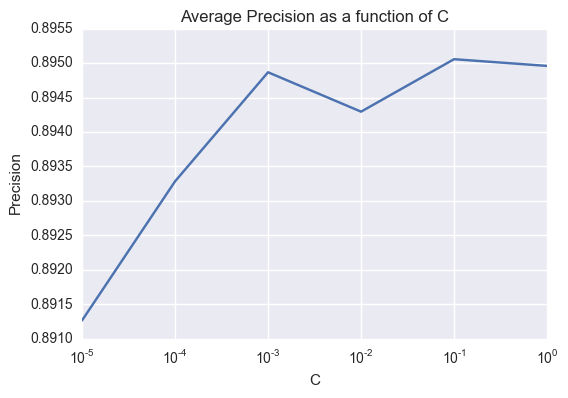

training logistic regression BIN_0
getting logistic regression predictions BIN_0
calculating logistic regression Performance on the train set: BIN_0
logistic regression train set auc: 0.903752417083
calculating logistic regression Performance on the test set: BIN_0
             precision    recall  f1-score   support

          0       0.82      0.63      0.71       508
          1       0.82      0.92      0.87       955

avg / total       0.82      0.82      0.82      1463

C=1e-05: 0.845406100004
C=0.0001: 0.851025306985
C=0.001: 0.859823075396
C=0.01: 0.863044623137
C=0.1: 0.865003281552
C=1.0: 0.86309644473


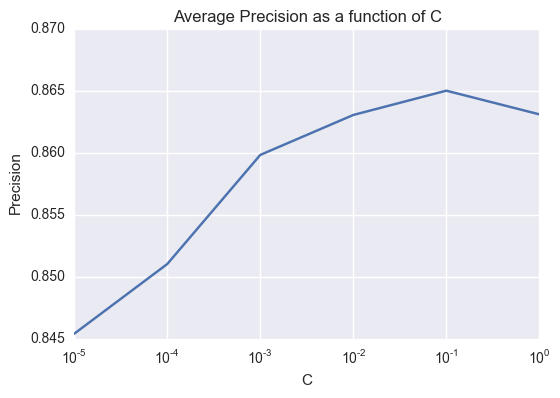

training logistic regression BIN_1
getting logistic regression predictions BIN_1
calculating logistic regression Performance on the train set: BIN_1
logistic regression train set auc: 0.869554770818
calculating logistic regression Performance on the test set: BIN_1
             precision    recall  f1-score   support

          0       0.83      0.85      0.84       860
          1       0.77      0.76      0.77       603

avg / total       0.81      0.81      0.81      1463

C=1e-05: 0.838154690803
C=0.0001: 0.846035502952
C=0.001: 0.861867845817
C=0.01: 0.877559442648
C=0.1: 0.876851631708
C=1.0: 0.873814960293


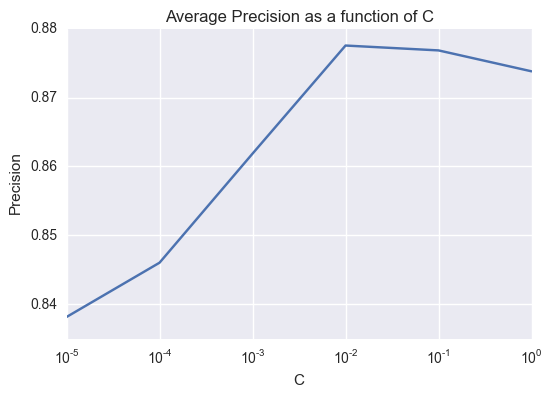

training logistic regression BIN_2
getting logistic regression predictions BIN_2
calculating logistic regression Performance on the train set: BIN_2
logistic regression train set auc: 0.878577568622
calculating logistic regression Performance on the test set: BIN_2
             precision    recall  f1-score   support

          0       0.87      0.96      0.91      1127
          1       0.80      0.53      0.64       336

avg / total       0.86      0.86      0.85      1463



In [33]:
for seperator in seperators:
    lr_train_len = train_len
    lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
    lr_ids = pp_data['id']

    lr_train_set = pp_data[:lr_train_len].copy()
    lr_val_set = pp_data[lr_train_len:].copy()

    lr_train_labels = lr_labels[:lr_train_len].copy()
    lr_val_labels = lr_labels[lr_train_len:].copy()

    lr_train_ids = lr_ids[:lr_train_len].copy()
    lr_val_ids = lr_ids[lr_train_len:].copy()

    lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_val_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_set = lr_train_set.append(lr_val_set, ignore_index=True)
    
    cv_scores = []
    space = np.logspace(-5,0, num=6)
    for c in space:
        res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='roc_auc')
        print "C=%s: %s" % (c, np.average(res))
        cv_scores.append(np.average(res))

    plot_cross_val(space, cv_scores, "C")
    lr_selceted_c = space[cv_scores.index(max(cv_scores))]
    
    print "training logistic regression", bin_names[seperators.index(seperator)]
    lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

    lr.fit(lr_train_set, lr_train_labels)
    print "getting logistic regression predictions", bin_names[seperators.index(seperator)]
    lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
    lr_predictions = lr.predict(lr_set)

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
    lr_val_predicted_probs = lr_predicted_probs[lr_train_len:]

    lr_train_predictions = lr_predictions[:lr_train_len]
    lr_val_predictions = lr_predictions[lr_train_len:]

    # attach LR predictions to the data as another feature
    pp_data['lr_prediction_%s' % bin_names[seperators.index(seperator)]] = lr_predictions.copy()
    pp_data['lr_prediction_proba_%s' % bin_names[seperators.index(seperator)]] = lr_predicted_probs.copy()

    print "calculating logistic regression Performance on the train set:", bin_names[seperators.index(seperator)]
    fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
    lr_auc = metrics.auc(fpr, tpr)
    print "logistic regression train set auc:", lr_auc
#     plotRoc(fpr, tpr, lr_auc)
    print "calculating logistic regression Performance on the test set:", bin_names[seperators.index(seperator)]
    print(metrics.classification_report(lr_val_labels, lr_val_predictions))
#     plotMetrics(lr_val_labels,lr_val_predicted_probs)


Deciding bin placements by logistic regressions binary predictions..
Got bin placements, 0 values determined by higher probability, 0 by probability sum, 8868 were definitive


ALL DATA:
[[1268  847  100    2]
 [ 341 1178  656   42]
 [ 110  695 1120  292]
 [  32  221  725 1239]]


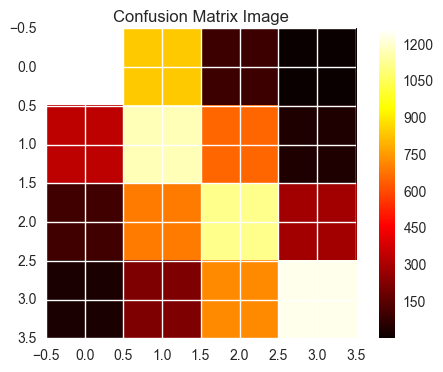

TEST SET ONLY:
[[386 213  24   0]
 [ 56 238 137  11]
 [ 13 108 152  45]
 [ 14  42 115 220]]


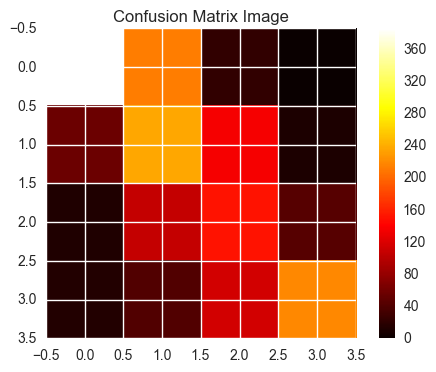

train score: 0.579903398497
train score: 0.536932619115
test score: 0.592819002579
test score: 0.561443066516


In [40]:
# unify predictions for bin classification
undef_1 = 0
undef_2 = 0

def decide_bin(row):
    global undef_1, undef_2
    preds = (row['lr_prediction_BIN_0'], row['lr_prediction_BIN_1'], row['lr_prediction_BIN_2'])
    pred_probas = (row['lr_prediction_proba_BIN_0'], row['lr_prediction_proba_BIN_1'], row['lr_prediction_proba_BIN_2'])

    if preds == (0, 0, 0):
        return 'BIN_0'
    elif preds == (1, 0, 0):
        return 'BIN_1'
    elif preds == (1, 1, 0):
        return 'BIN_2'
    elif preds == (1, 1, 1):
        return 'BIN_3'
    
    undef_1 += 1
    if preds[0] == 0 and pred_probas[0] < (1 - pred_probas[1]) and pred_probas[0] < (1 - pred_probas[2]):
        return 'BIN_0'

    if preds[2] == 1 and pred_probas[2] > (1 - pred_probas[1]) and pred_probas[2] > (1 - pred_probas[0]):
        return 'BIN_3'
    
    undef_2 += 1
    return 'BIN_%s' % int(round(sum(pred_probas)))

print "Deciding bin placements by logistic regressions binary predictions.."
bin_predictions = pp_data.apply(decide_bin, axis=1)
print "Got bin placements, %s values determined by higher probability, %s by probability sum, %s were definitive\n\n" % (undef_1, undef_2, pp_data.id.count() - undef_1 - undef_2)

print "========="
print "ALL DATA:"
print "========="
m = confusion_matrix(pp_data['labels'].values, bin_predictions.values)
print m
plotConfusion(m, 4)

print "=============="
print "TEST SET ONLY:"
print "=============="
m = confusion_matrix(pp_data['labels'][lr_train_len:].values, bin_predictions[lr_train_len:].values)
print m
plotConfusion(m, 4)

print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='macro')
print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='micro')
# print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='samples')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='macro')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='micro')
# print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='samples')

prediction_cols = ['lr_prediction_BIN_0', 'lr_prediction_BIN_1', 'lr_prediction_BIN_2', 'lr_prediction_proba_BIN_0', 'lr_prediction_proba_BIN_1', 'lr_prediction_proba_BIN_2']


4
0


IndexError: index 0 is out of bounds for axis 1 with size 0

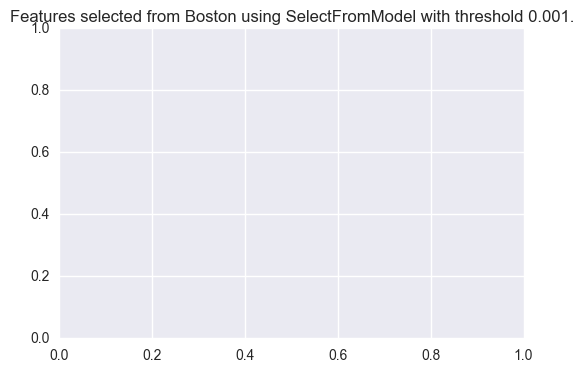

In [106]:
lr_train_len = train_len
lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= 50000 else 1)
# lr_labels = pp_data['labels'].apply(lambda x: int(x[-1]))
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_val_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_val_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_val_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_val_set.drop(['likes', 'id', 'labels'], 1, inplace=True)

# sfm = SelectFromModel(lm.LassoCV())
# sfm.fit(lr_train_set, lr_train_labels)
# n_features = sfm.transform(lr_train_set).shape[1]
# print n_features

# # Reset the threshold till the number of features equals two.
# # Note that the attribute can be set directly instead of repeatedly
# # fitting the metatransformer.
# while n_features > 2:
#     sfm.threshold += 0.001
#     X_transform = sfm.transform(lr_train_set)
#     n_features = X_transform.shape[1]
#     print n_features

# # Plot the selected two features from X.
# plt.title(
#     "Features selected from Boston using SelectFromModel with "
#     "threshold %0.3f." % sfm.threshold)
# feature1 = X_transform[:, 0]
# feature2 = X_transform[:, 1]
# plt.plot(feature1, feature2, 'r.')
# plt.xlabel("Feature number 1")
# plt.ylabel("Feature number 2")
# plt.ylim([np.min(feature2), np.max(feature2)])
# plt.show()

### Preprocessing

In [36]:
# lr_labelsfrom sklearn.metrics import confusion_matrixfrom sklearn.metrics import confusion_matrix = pp_data['likes']
lr_train_len = train_len
lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
lr_ids = pp_data['id']

lr_train_set = pp_data[:lr_train_len].copy()
lr_val_set = pp_data[lr_train_len:].copy()

lr_train_labels = lr_labels[:lr_train_len].copy()
lr_val_labels = lr_labels[lr_train_len:].copy()

lr_train_ids = lr_ids[:lr_train_len].copy()
lr_val_ids = lr_ids[lr_train_len:].copy()

lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_val_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
lr_set = lr_train_set.append(lr_val_set, ignore_index=True)

### Parameter optimization

C=1e-12: 0.866633983332
C=1e-11: 0.879851560951
C=1e-10: 0.883927165336
C=1e-09: 0.890033280944
C=1e-08: 0.888102944427
C=1e-07: 0.893298975005
C=1e-06: 0.902186580893
C=1e-05: 0.904886141368


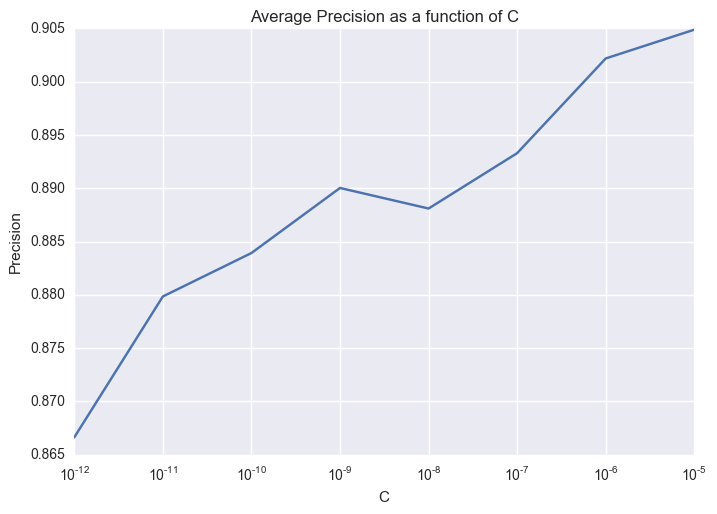

In [37]:
cv_scores = []
space = np.logspace(-10,-2, num=8)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

C=1e-10: 0.883927165336
C=2.15443469003e-10: 0.887292982014
C=4.64158883361e-10: 0.889880287287
C=1e-09: 0.890033280944
C=2.15443469003e-09: 0.889221849537
C=4.64158883361e-09: 0.888324973356
C=1e-08: 0.888102944265


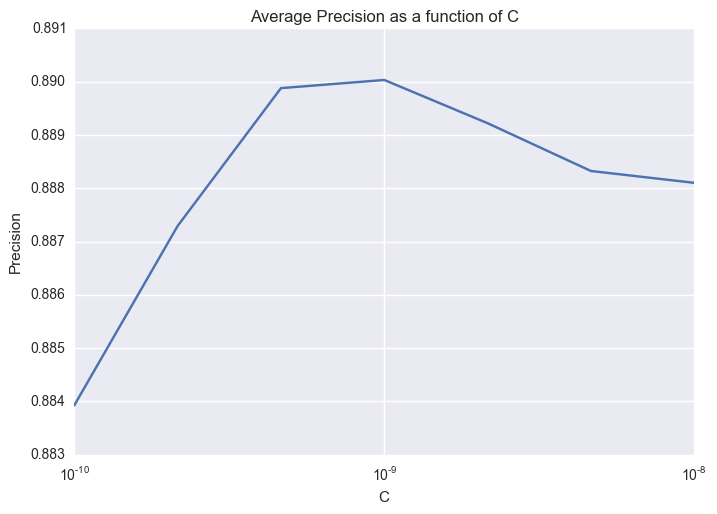

In [38]:
cv_scores = []
space = np.logspace(-10,-8, num=7)
for c in space:
    res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='average_precision')
    print "C=%s: %s" % (c, np.average(res))
    cv_scores.append(np.average(res))

plot_cross_val(space, cv_scores, "C")
lr_selceted_c = space[cv_scores.index(max(cv_scores))]

### LR running 

training logistic regression
getting logistic regression predictions
calculating logistic regression Performance on the train set:
logistic regression train set auc: 0.865343621882


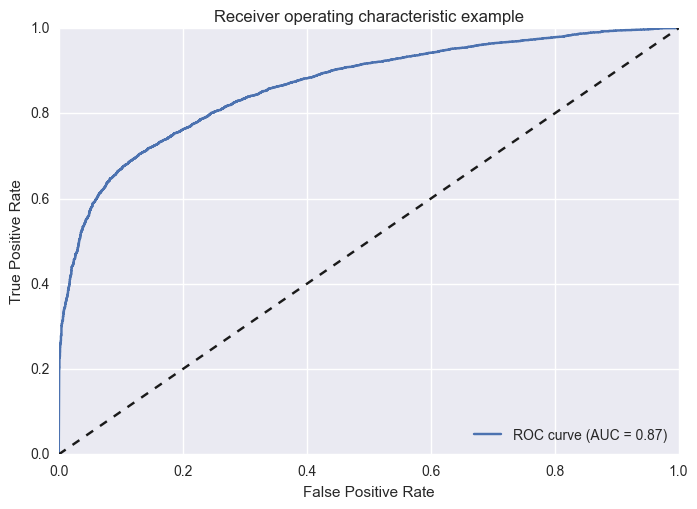

calculating logistic regression Performance on the test set:
             precision    recall  f1-score   support

          0       0.78      0.92      0.84      1506
          1       0.84      0.63      0.72      1059

avg / total       0.81      0.80      0.79      2565



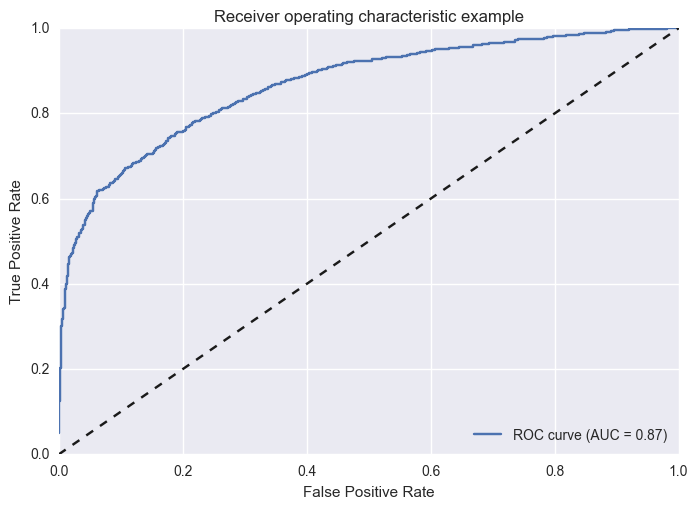

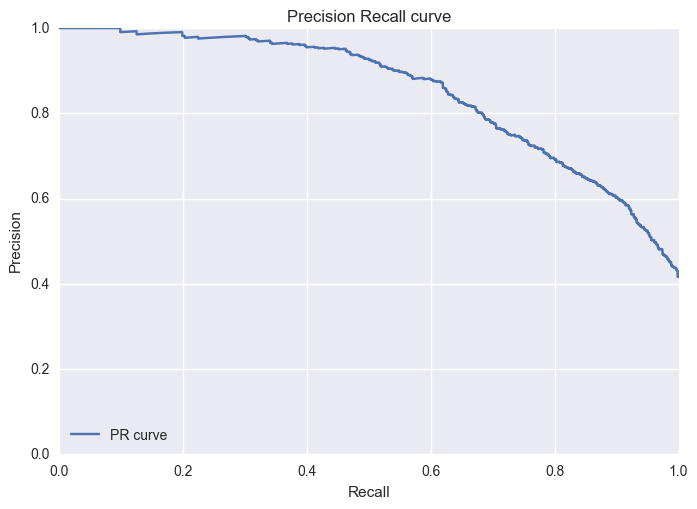

In [39]:
print "training logistic regression"
lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

lr.fit(lr_train_set, lr_train_labels)
print "getting logistic regression predictions"
lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
lr_predictions = lr.predict(lr_set)

lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
lr_val_predicted_probs = lr_predicted_probs[lr_train_len:]

lr_train_predictions = lr_predictions[:lr_train_len]
lr_val_predictions = lr_predictions[lr_train_len:]

# attach LR predictions to the data as another feature
pp_data['lr_prediction'] = lr_predictions.copy()

print "calculating logistic regression Performance on the train set:"
fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
lr_auc = metrics.auc(fpr, tpr)
print "logistic regression train set auc:", lr_auc
plotRoc(fpr, tpr, lr_auc)
print "calculating logistic regression Performance on the test set:"
print(metrics.classification_report(lr_val_labels, lr_val_predictions))
plotMetrics(lr_val_labels,lr_val_predicted_probs)

# pected = val_class.values
# oh_val_data= oh_test.drop('class',axis=1)
# predicted = logreg.predict(oh_val_data)
# predicted_probs = logreg.predict_proba(oh_val_data)

#add LR score as a new feature
# train_set['logistic_regression_prediction'] = lr_train_predictions
# val_set['logistic_regression_prediction'] = lr_val_predictions

# SVM

### Generate preprocessed data sets (save/load from disk to save time)

In [ ]:
# Getting feature selections from disk

# import json

# feat_sel_list = get_feat_sel(lr_train_set, lr_val_set, lr_train_labels, lr_val_labels, svm.SVC(class_weight='balanced', C=100, kernel='linear'), verbose=True)
# with open('data_sets\SVM.json', 'w') as svmf:
#     svmf.write(json.dumps(feat_sel_list))

# data_sets = get_data_sets_from_disk("SVM")
with open('data_sets\SVM.json', 'r') as svmf:
    feat_sel_list = json.loads(svmf.read())

### Preprocessing

In [20]:
unscaled_svm_pp_data = pp_data.copy()
svm_train_len = train_len
svm_val_len = int(len(pp_data['id'])) - train_len
# svm_pp_data.drop(categorical_variables, 1, inplace=True)


svm_labels = unscaled_svm_pp_data['labels'].apply(lambda x: 0 if (x == 'BIN_0' or x == 'BIN_1') else 1)
svm_multi_labels = unscaled_svm_pp_data['labels'].map({'BIN_0':0, 'BIN_1':1, 'BIN_2':2, 'BIN_3':3})
svm_ids = unscaled_svm_pp_data['id']

unscaled_svm_pp_data.drop(['likes', 'labels', 'id'], 1, inplace=True)
svm_pp_data = preprocessing.minmax_scale(unscaled_svm_pp_data)


svm_train_set = svm_pp_data[:svm_train_len].copy()
svm_val_set = svm_pp_data[svm_train_len:svm_train_len+svm_val_len].copy()

svm_train_labels = svm_labels[:svm_train_len].copy()
svm_val_labels = svm_labels[svm_train_len:svm_train_len+svm_val_len].copy()

svm_train_multi_labels = svm_multi_labels[:svm_train_len].copy()
svm_val_multi_labels = svm_multi_labels[svm_train_len:svm_train_len+svm_val_len].copy()

svm_train_ids = svm_ids[:svm_train_len].copy()
svm_val_ids = svm_ids[svm_train_len:svm_train_len+svm_val_len].copy()

## Binary separetors

In [21]:
svm_set = np.append(svm_train_set,svm_val_set, axis=0)

pca = PCA()
pca.fit(svm_train_set)
pca_svm_set = pca.transform(svm_set)
pca_svm_tarin_set = pca_svm_set[:train_len]
pca_svm_val_set = pca_svm_set[train_len:]

In [22]:
svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(pca_svm_tarin_set, svm_train_labels)

svm_train_pred = svm_model.predict(pca_svm_tarin_set)
train_acc = metrics.accuracy_score(svm_train_labels, svm_train_pred)

svm_val_pred = svm_model.predict(pca_svm_val_set)
val_acc = metrics.accuracy_score(svm_val_labels, svm_val_pred)


print "TRAIN ACCURACY:  " + str(train_acc)
print "=============="
print "TEST ACCURACY:  " + str(val_acc)
print "============="

TRAIN ACCURACY:  0.840564097542
TEST ACCURACY:  0.814336075206


In [27]:
svm_set = np.append(svm_train_set,svm_val_set, axis=0)

pca = PCA(80)
pca.fit(svm_train_set)
pca_svm_set = pca.transform(svm_set)
pca_svm_tarin_set = pca_svm_set[:train_len]
pca_svm_val_set = pca_svm_set[train_len:]

In [28]:
svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(pca_svm_tarin_set, svm_train_labels)

svm_train_pred = svm_model.predict(pca_svm_tarin_set)
train_acc = metrics.accuracy_score(svm_train_labels, svm_train_pred)

svm_val_pred = svm_model.predict(pca_svm_val_set)
val_acc = metrics.accuracy_score(svm_val_labels, svm_val_pred)


print "TRAIN ACCURACY:  " + str(train_acc)
print "=============="
print "TEST ACCURACY:  " + str(val_acc)
print "============="

TRAIN ACCURACY:  0.832239741455
TEST ACCURACY:  0.801801801802


### Parameter optimization 

In [ ]:
cv_scores = []
cs = []
for c in range(-12,-3):#-2,2):
    res = cross_val_score(svm.SVC(C=10**c), svm_train_set, svm_train_labels, cv=3, scoring='roc_auc')
    print "C=%s: %s" % (10**c, np.average(res))
    cs.append(10**c)
    cv_scores.append(np.average(res))
    
plot_cross_val(cs, cv_scores, "C")
svm_selceted_c = cv_scores[cv_scores.index(max(cv_scores))]

In [ ]:
cv_scores = []
cs = []
for c in range(-15,-3):
    res = cross_val_score(svm.SVC(C=10**c), svm_train_set, svm_train_labels,scoring='average_precision')
    print "C=%s: %s" % (10**c, np.average(res))
    cs.append(10**c)
    cv_scores.append(np.average(res))
    
plot_cross_val(cs, cv_scores, "C")
svm_selceted_c = cv_scores[cv_scores.index(max(cv_scores))]

#TODO: add cv for gemma

In [ ]:
from sklearn.model_selection import GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
clf = clf.fit(svm_train_set, svm_train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

### SVM run

In [ ]:
# svm_selceted_c = 16.681005372
# svm_selceted_gamma = 0.0316227766017

# svm_model = svm.SVC(probability=True, C=svm_selceted_c)#, gamma=svm_selceted_gamma)

In [19]:
svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(svm_train_set, svm_train_labels)

svm_train_pred = svm_model.predict(svm_train_set)
train_acc = metrics.accuracy_score(svm_train_labels, svm_train_pred)

svm_val_pred = svm_model.predict(svm_val_set)
val_acc = metrics.accuracy_score(svm_val_labels, svm_val_pred)


print "TRAIN ACCURACY:  " + str(train_acc)
print "=============="
print "TEST ACCURACY:  " + str(val_acc)
print "============="


TRAIN ACCURACY:  0.838605425521
TEST ACCURACY:  0.805718762241


calculating SVM Performance on the train set:
svm train set auc: 0.917719521577


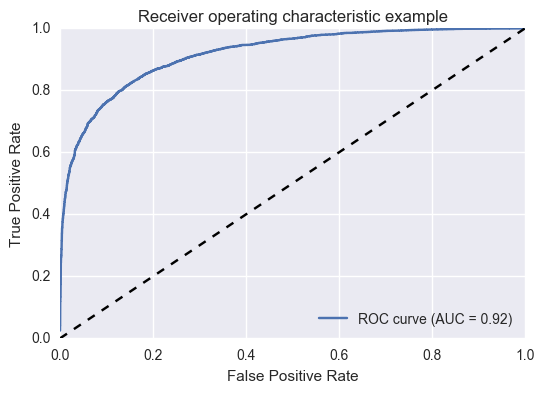

calculating SVM Performance on the test set:
svm test set auc: 0.867541870373


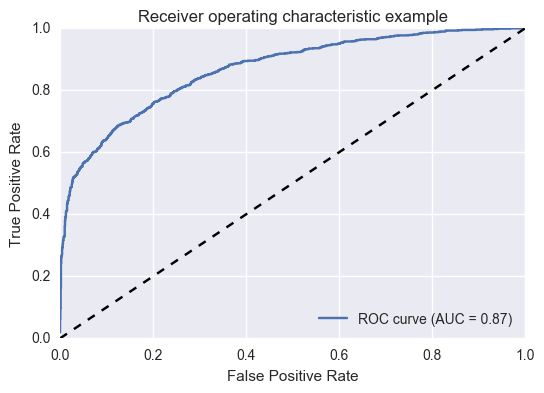

             precision    recall  f1-score   support

          0       0.82      0.86      0.84      1586
          1       0.75      0.70      0.72       967

avg / total       0.79      0.80      0.79      2553



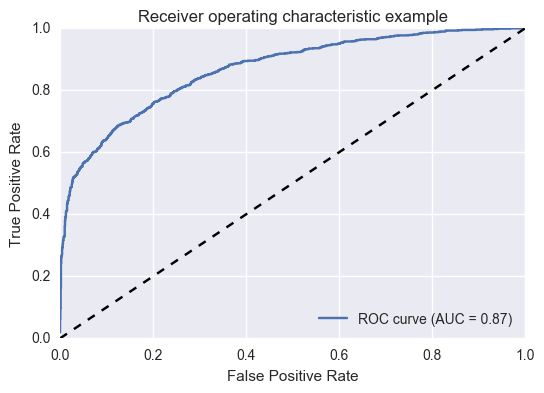

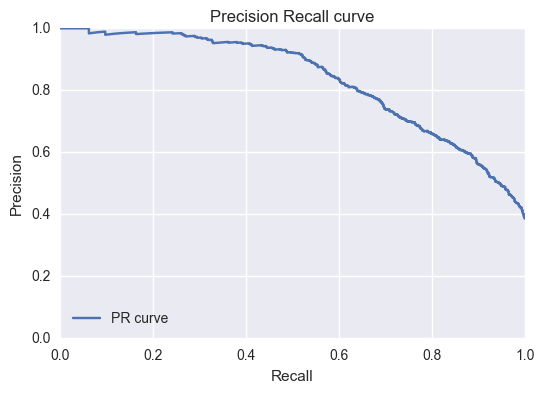

In [34]:
svm_model = svm.SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


svm_model.fit(svm_train_set, svm_train_labels)

svm_train_prediction = svm_model.predict(svm_train_set)
svm_val_prediction = svm_model.predict(svm_val_set)

svm_train_predicted_probs = svm_model.predict_proba(svm_train_set)[:, 1]
svm_val_predicted_probs = svm_model.predict_proba(svm_val_set)[:, 1]

#TODO: refactor this to genric function
print "calculating SVM Performance on the train set:"
fpr, tpr, thresholds = metrics.roc_curve(svm_train_labels, svm_train_predicted_probs)
svm_train_auc = metrics.auc(fpr, tpr)
print "svm train set auc:", svm_train_auc
plotRoc(fpr, tpr, svm_train_auc)

print "calculating SVM Performance on the test set:"
fpr, tpr, thresholds = metrics.roc_curve(svm_val_labels, svm_val_predicted_probs)
svm_val_auc = metrics.auc(fpr, tpr)
print "svm test set auc:", svm_val_auc
plotRoc(fpr, tpr, svm_val_auc)

print(metrics.classification_report(svm_val_labels, svm_val_prediction))
plotMetrics(svm_val_labels,svm_val_predicted_probs)

In [22]:
from sklearn.model_selection import GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [0.01, 0.1, 1, 10], 'kernel': ['rbf', 'linear']}
clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
clf = clf.fit(svm_train_set, svm_train_multi_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


## Multi Calss SVM

### Parameter optimization 

In [100]:
from sklearn.model_selection import GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel': ['rbf', 'linear']}
clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
clf = clf.fit(svm_train_set, svm_train_multi_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### SVM run

MULTI-CLASS TRAIN ACCURACY:  0.671824502987
[[1876  452   67    2]
 [ 497 1284  582   36]
 [ 120  588 1554  396]
 [  27   81  503 2146]]


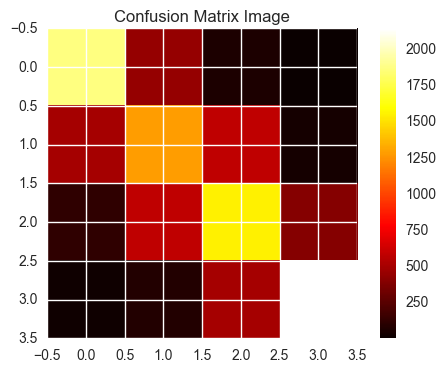

MULTI-CLASS TEST ACCURACY:  0.585193889542
[[544 229  21   0]
 [198 412 174   8]
 [ 34 178 246  75]
 [  3  36 103 292]]


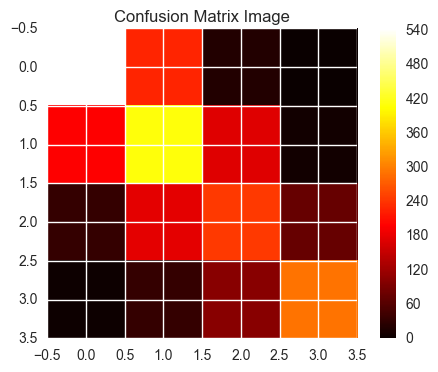

In [21]:
svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(svm_train_set, svm_train_multi_labels)

svm_train_pred = svm_model.predict(svm_train_set)
train_acc = metrics.accuracy_score(svm_train_multi_labels, svm_train_pred)

svm_val_pred = svm_model.predict(svm_val_set)
val_acc = metrics.accuracy_score(svm_val_multi_labels, svm_val_pred)

print "MULTI-CLASS TRAIN ACCURACY:  " + str(train_acc)
print "=========================="
m = confusion_matrix(svm_train_multi_labels, svm_train_pred)
print m
plotConfusion(m, 4)

print "MULTI-CLASS TEST ACCURACY:  " + str(val_acc)
print "========================="

m = confusion_matrix(svm_val_multi_labels, svm_val_pred)
print m
plotConfusion(m, 4)

## KNN

test accuracy for k = 2:  0.414023
test accuracy for k = 6:  0.437524
test accuracy for k = 10:  0.426949
test accuracy for k = 14:  0.414414
test accuracy for k = 18:  0.412848
test accuracy for k = 22:  0.403055
test accuracy for k = 26:  0.419506
test accuracy for k = 30:  0.421073
test accuracy for k = 34:  0.425774
test accuracy for k = 38:  0.418331
test accuracy for k = 42:  0.426949
test accuracy for k = 46:  0.427340
test accuracy for k = 50:  0.428515
test accuracy for k = 54:  0.428124
test accuracy for k = 58:  0.426557
test accuracy for k = 62:  0.423423
test accuracy for k = 66:  0.427340
test accuracy for k = 70:  0.426165


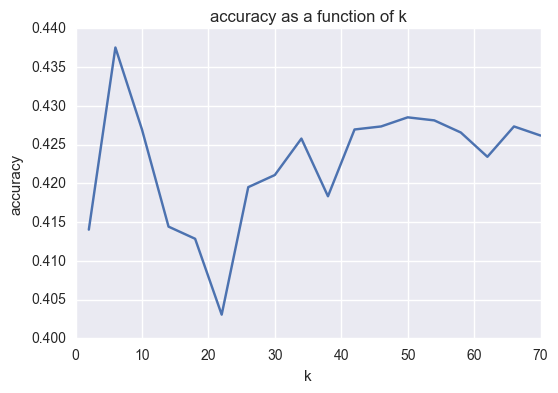

In [23]:
knn_tarin_set = svm_train_set.copy()
knn_val_set = svm_val_set.copy()

knn_train_labels = svm_train_multi_labels.copy()
knn_val_labels = svm_val_multi_labels.copy()

k_range = [k for k in range(2,71,4)]
val_accuracies = []

for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(knn_tarin_set, knn_train_labels)
    knn_val_pred = knn.predict(knn_val_set)
    val_acc = metrics.accuracy_score(knn_val_labels, knn_val_pred)
    print "test accuracy for k = %d:  %f" %(k, val_acc)
    val_accuracies.append(val_acc)

plot_results(k_range, val_accuracies, "accuracy", "k")

test accuracy for k = 2:  0.422640
test accuracy for k = 6:  0.434391
test accuracy for k = 10:  0.441833
test accuracy for k = 14:  0.434391
test accuracy for k = 18:  0.446533
test accuracy for k = 22:  0.450059
test accuracy for k = 26:  0.436349
test accuracy for k = 30:  0.444575
test accuracy for k = 34:  0.441833
test accuracy for k = 38:  0.441833
test accuracy for k = 42:  0.442617
test accuracy for k = 46:  0.436741
test accuracy for k = 50:  0.442617
test accuracy for k = 54:  0.443400
test accuracy for k = 58:  0.441441
test accuracy for k = 62:  0.433999
test accuracy for k = 66:  0.439091
test accuracy for k = 70:  0.433216


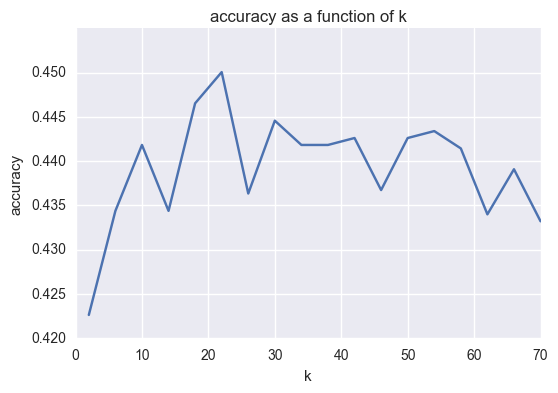

In [20]:
from sklearn.decomposition import PCA

knn_tarin_set = svm_train_set.copy()
knn_val_set = svm_val_set.copy()
knn_train_labels = svm_train_multi_labels.copy()
knn_val_labels = svm_val_multi_labels.copy()

knn_set = np.append(knn_tarin_set,knn_val_set, axis=0)

pca = PCA()
pca.fit(knn_tarin_set)
pca_knn_set = pca.transform(knn_set)
pca_knn_tarin_set = pca_knn_set[:train_len]
pca_knn_val_set = pca_knn_set[train_len:]


knn_train_labels = svm_train_multi_labels.copy()
knn_val_labels = svm_val_multi_labels.copy()

k_range = [k for k in range(2,71,4)]
val_accuracies = []

for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(pca_knn_tarin_set, knn_train_labels)
    knn_val_pred = knn.predict(pca_knn_val_set)
    val_acc = metrics.accuracy_score(knn_val_labels, knn_val_pred)
    print "test accuracy for k = %d:  %f" %(k, val_acc)
    val_accuracies.append(val_acc)

plot_results(k_range, val_accuracies, "accuracy", "k")

test accuracy for k = 2:  0.414023
test accuracy for k = 3:  0.422248
test accuracy for k = 4:  0.429299
test accuracy for k = 5:  0.441441
test accuracy for k = 6:  0.437524
test accuracy for k = 7:  0.425382
test accuracy for k = 8:  0.415590
test accuracy for k = 9:  0.426557


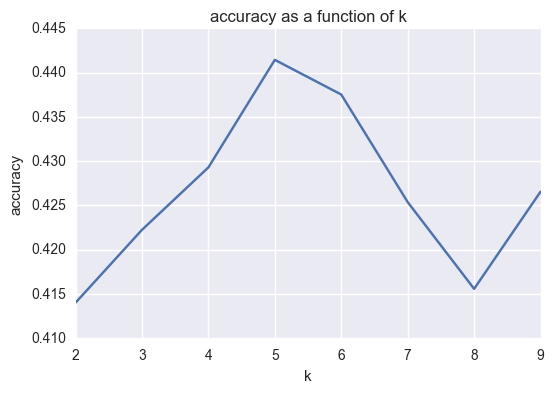

In [24]:
k_range = [k for k in range(2,10)]
val_accuracies = []

for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(knn_tarin_set, knn_train_labels)
    knn_val_pred = knn.predict(knn_val_set)
    val_acc = metrics.accuracy_score(knn_val_labels, knn_val_pred)
    print "test accuracy for k = %d:  %f" %(k, val_acc)
    val_accuracies.append(val_acc)

plot_results(k_range, val_accuracies, "accuracy", "k")

## Random Forest

### Preprocessing

In [70]:
rf_train_len = train_len

rf_train_set = pp_data[:train_len].copy()
rf_val_set = pp_data[train_len:].copy()

rf_train_likes = rf_train_set['likes'].copy()
rf_val_likes = rf_val_set['likes'].copy()

# rf_train_labels = binning(rf_train_likes, bin_num)
# rf_val_labels = binning(rf_val_likes, bin_num)

rf_train_ids = rf_train_set['id'].copy()
rf_val_ids = rf_val_set['id'].copy()

rf_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
rf_val_set.drop(['likes', 'id', 'labels'], 1, inplace=True)

### Parameter optimization

Feature ranking - Top 10:
1. feature 81 (talking_about_count)
   score: 0.067665
2. feature 53 (self_feed_avg_likes)
   score: 0.038871
3. feature 74 (self_feed_std_likes)
   score: 0.038655
4. feature 11 (photo_avg_likes_per_photo)
   score: 0.034597
5. feature 62 (self_feed_max_likes)
   score: 0.033834
6. feature 16 (photo_max_like)
   score: 0.033727
7. feature 94 (posting_freq)
   score: 0.031177
8. feature 27 (photo_number_of_days_between_first_and_last_photos)
   score: 0.030377
9. feature 26 (total_photos)
   score: 0.029514
10. feature 57 (self_feed_number_of_days_between_first_and_last_posts)
   score: 0.025936


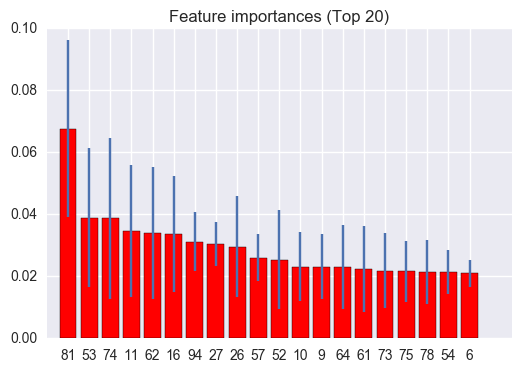

In [77]:
# Parameter optimization for 8 bin
bin_num = 8
rf_train_labels = binning(rf_train_likes, bin_num)
rf_val_labels = binning(rf_val_likes, bin_num)

forest = RandomForestClassifier(n_estimators=250, max_depth=15)
forest.fit(rf_train_set.values, rf_train_labels.values)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking - Top 10:")
for f in range(10):
    print("%d. feature %d (%s)\n   score: %f" % (f + 1, indices[f], list(rf_train_set)[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plot_idxs = indices[:20]
plt.figure()
plt.title("Feature importances (Top 20)")
plt.bar(range(20), importances[plot_idxs],
       color="r", yerr=std[plot_idxs], align="center")
plt.xticks(range(20), plot_idxs)
plt.xlim([-1, 21])
plt.show()

In [139]:
importances_thresholds = [0, 0.005, 0.01, 0.015, 0.02]#, 0.025]#, 0.03] 
max_depths = [10, 20, 30, None] 
min_samples_leaf = [1] #[1, 3, 5]

filtered_by_thresholds = []
for t in importances_thresholds:
    columns = []
    for f in range(rf_train_set.shape[1]):
        if importances[indices[f]] >= t:
            columns.append(list(rf_train_set)[indices[f]])
    filtered_by_thresholds.append(columns)

params = []
score_summary = []
oobs = []
print "(threshold, depth, min_samples) -> average precision score, oob error"
for i in range(len(filtered_by_thresholds)):
    for d in max_depths:
        for l in min_samples_leaf:
            cols = filtered_by_thresholds[i]
            forest = RandomForestClassifier(n_estimators=250, random_state=0, oob_score=True, max_depth=d, min_samples_leaf=l)
            forest.fit(rf_train_set[cols], rf_train_labels)
            temp_predictions = forest.predict(rf_val_set[cols])
            res = metrics.precision_score(rf_val_labels, temp_predictions, average='macro')
            oob_error = 1 - forest.oob_score_
            score_summary.append(res)
            oobs.append(oob_error)
            params.append((importances_thresholds[i], d, l))
            print "params: %s -> precision: %s, oob error: %s" % (params[-1], score_summary[-1], oobs[-1])
    
max_idx = np.argmax(score_summary)
best_threshold = params[max_idx][0]
best_max_depth = params[max_idx][1]
best_min_leaf = params[max_idx][2]

# Print best hyper parameters
print "RF best parameters:"
print "max_depth = ", best_max_depth
print "importance_threshold = ", best_threshold
print "min_samples_leaf = ", best_min_leaf

(threshold, depth, min_samples) -> average precision score, oob error
params: (0, 10, 1) -> precision: 0.373903582669, oob error: 0.572617765155
params: (0, 20, 1) -> precision: 0.381068848118, oob error: 0.569875624327
params: (0, 30, 1) -> precision: 0.3736605081, oob error: 0.569679757125
params: (0, None, 1) -> precision: 0.368350491706, oob error: 0.568602487513
params: (0.005, 10, 1) -> precision: 0.380030167924, oob error: 0.578787582019
params: (0.005, 20, 1) -> precision: 0.364743966247, oob error: 0.571344628342
params: (0.005, 30, 1) -> precision: 0.378505481831, oob error: 0.573792968367
params: (0.005, None, 1) -> precision: 0.372854530185, oob error: 0.572030163549
params: (0.01, 10, 1) -> precision: 0.375791372771, oob error: 0.574674370777
params: (0.01, 20, 1) -> precision: 0.37104486975, oob error: 0.57496817158
params: (0.01, 30, 1) -> precision: 0.371656093254, oob error: 0.573890901968
params: (0.01, None, 1) -> precision: 0.366024336895, oob error: 0.573792968367


### Model evaluation

RANDOM FOREST TEST RESULTS
calculating Random Forest Performance on the test set:

classification report:
             precision    recall  f1-score   support

      BIN_0       0.48      0.77      0.59       320
      BIN_1       0.23      0.36      0.28       319
      BIN_2       0.24      0.28      0.26       319
      BIN_3       0.22      0.24      0.23       319
      BIN_4       0.24      0.17      0.20       319
      BIN_5       0.28      0.18      0.22       319
      BIN_6       0.44      0.27      0.33       319
      BIN_7       0.91      0.59      0.72       319

avg / total       0.38      0.36      0.35      2553


confusion matrix with 8 bins: 
[[245  61  12   1   1   0   0   0]
 [126 116  54  19   4   0   0   0]
 [ 42 120  89  47  15   4   2   0]
 [ 46  92  65  75  26  13   2   0]
 [ 30  52  74  77  55  26   5   0]
 [ 14  44  47  63  71  59  21   0]
 [  6  14  22  44  47  83  85  18]
 [  1   3   3  10   9  25  80 188]]


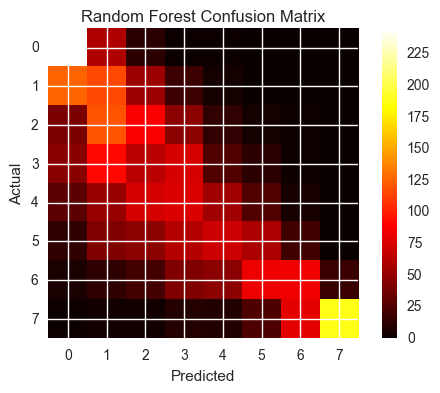

In [136]:
bin_num = 8
rf_train_labels = binning(rf_train_likes, bin_num)
rf_val_labels = binning(rf_val_likes, bin_num)

fc = filtered_by_thresholds[importances_thresholds.index(best_threshold)]
forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_train_predictions = forest.predict(rf_train_set[fc])
rf_val_predicted_probs = forest.predict_proba(rf_val_set[fc])
rf_val_predictions = forest.predict(rf_val_set[fc])

eval_model("Random Forest", rf_val_labels, rf_val_predictions, rf_val_predicted_probs, 
           is_test=True, bin_num=bin_num)

RANDOM FOREST TEST RESULTS
calculating Random Forest Performance on the test set:

classification report:
             precision    recall  f1-score   support

      BIN_0       0.59      0.83      0.69       639
      BIN_1       0.42      0.53      0.47       638
      BIN_2       0.46      0.34      0.39       638
      BIN_3       0.94      0.54      0.69       638

avg / total       0.60      0.56      0.56      2553


confusion matrix with 4 bins: 
[[530 106   3   0]
 [247 339  51   1]
 [102 298 216  22]
 [ 14  73 204 347]]


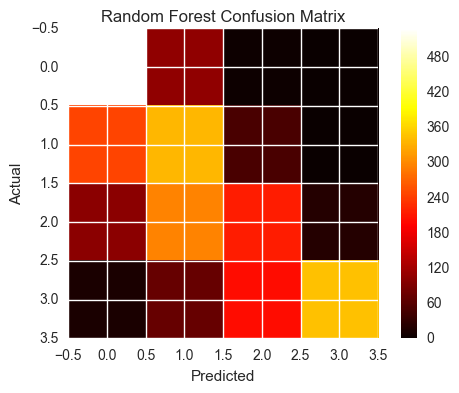

In [135]:
bin_num = 4
rf_train_labels = binning(rf_train_likes, bin_num)
rf_val_labels = binning(rf_val_likes, bin_num)

fc = filtered_by_thresholds[importances_thresholds.index(best_threshold)]
forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_val_predicted_probs = forest.predict_proba(rf_val_set[fc])
rf_val_predictions = forest.predict(rf_val_set[fc])

eval_model("Random Forest", rf_val_labels, rf_val_predictions, rf_val_predicted_probs, 
           is_test=True, bin_num=bin_num)

## Linear Regression

In [49]:
linr_pp_data = pp_data.copy()
linr_train_len = train_len
linr_val_len = int(len(pp_data['id'])) - train_len

linr_labels = linr_pp_data['likes'].apply(lambda x: np.log(x) if x > 0 else 0)
linr_ids = linr_pp_data['id']


######
linr_bin_labels = linr_pp_data['labels'].copy()
linr_train_set_bin_labels = linr_bin_labels[:train_len]
linr_val_set_bin_labels = linr_bin_labels[train_len:]
linr_likes = linr_pp_data['likes'].copy()
#####

linr_pp_data.drop(['likes', 'labels', 'id'], 1, inplace=True)

# linr_data = preprocessing.minmax_scale(linr_pp_data) #TODO: remove this!

linr_train_set = linr_data[:linr_train_len].copy()
linr_val_set = linr_data[linr_train_len:linr_train_len+linr_val_len].copy()

linr_train_labels = linr_labels[:linr_train_len].copy()
linr_val_labels = linr_labels[linr_train_len:linr_train_len+linr_val_len].copy()

linr_train_ids = linr_ids[:linr_train_len].copy()
linr_val_ids = linr_ids[linr_train_len:linr_train_len+linr_val_len].copy()

linr = sklearn.linear_model.LinearRegression()
linr.fit(linr_train_set, linr_train_labels)

train_predictions = linr.predict(linr_train_set)
val_predictions = linr.predict(linr_val_set)

# The coefficients
print 'Coefficients: '
coefs = linr.coef_
features = linr_pp_data.columns.get_values().tolist()
lst = []
for i in range(len(features)):
    lst.append((features[i], coefs[i]))
feat_coef = sorted(lst, key=lambda x: x[1])
feat_coef_str = ""
for a in feat_coef:
    feat_coef_str += a[0] + ": " + str(a[1]) +", "
print feat_coef_str[:-2]

# The mean squared error
print "\n\nMean squared error: %.2f" %(np.mean((linr.predict(linr_train_set) - linr_train_labels) ** 2))
# Explained variance score: 1 is perfect prediction
print 'training variance score: %.2f' %(linr.score(linr_train_set, linr_train_labels))
print 'test variance score: %.2f' %(linr.score(linr_val_set, linr_val_labels))

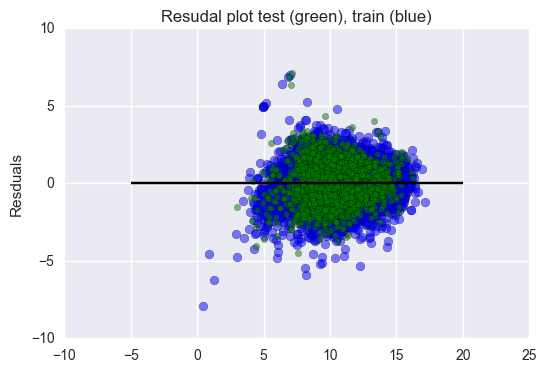

In [51]:
plt.scatter(train_predictions, train_predictions -  linr_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(val_predictions, val_predictions -  linr_val_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=-5, xmax=20)
plt.title('Resudal plot test (green), train (blue)')
plt.ylabel('Resduals')
plt.show()

Linear Regression train precision fot 4 bins: 0.635215
[[1904  591   57    1]
 [ 543 1255  707   48]
 [  96  618 1331  507]
 [  10   90  457 1996]]


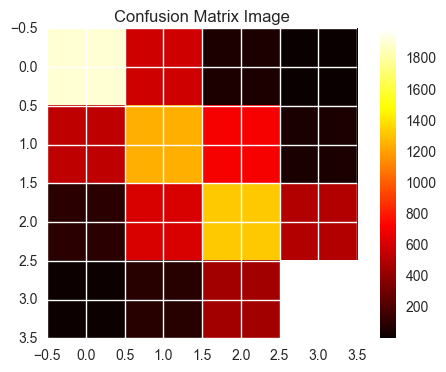

Linear Regression train precision fot 8 bins: 0.412161
[[865 312  73  22   4   1   0   0]
 [279 448 350 146  43   9   1   0]
 [ 78 304 382 288 165  50   9   0]
 [ 30 131 243 342 316 176  36   3]
 [ 18  46 145 266 343 312 138   8]
 [  5  27  63 144 274 402 289  72]
 [  0   5  22  61 109 276 518 285]
 [  2   3   1   6  21  51 284 909]]


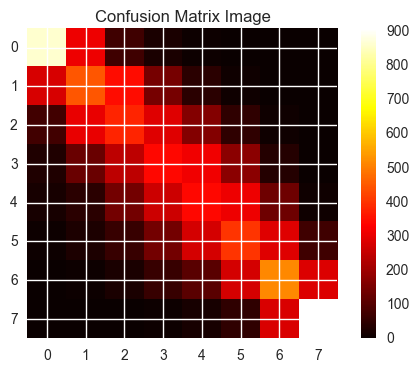

In [52]:
exp_pred = np.exp(train_predictions)

for bin_num in [4,8]:
    train_pred_bins = binning(exp_pred, bin_num)

    linr_train_set_bin_labels = binning(linr_likes[:train_len], bin_num)

    acc = metrics.precision_score(linr_train_set_bin_labels.values, train_pred_bins, average='macro')
    print "Linear Regression train precision fot %d bins: %f" %(bin_num, acc)

    m = confusion_matrix(linr_train_set_bin_labels.values, train_pred_bins)
    print m
    plotConfusion(m, bin_num)

Linear Regression test precision fot 4 bins: 0.579269
[[451 150  36   2]
 [143 280 198  17]
 [ 42 179 273 144]
 [  3  29 131 475]]


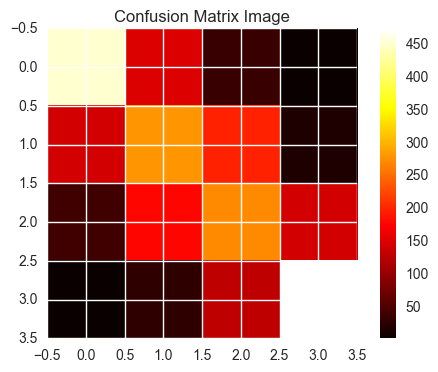

Linear Regression test precision fot 8 bins: 0.364985
[[179  98  30   8   5   0   0   0]
 [ 72 102  73  39  24   7   2   0]
 [ 23  53  79  86  47  22   8   1]
 [ 30  37  56  59  70  59   8   0]
 [ 14  15  38  60  74  67  47   4]
 [  1  12  34  47  53  79  77  16]
 [  1   2   7  18  38  73 121  59]
 [  0   0   2   2   8  12  56 239]]


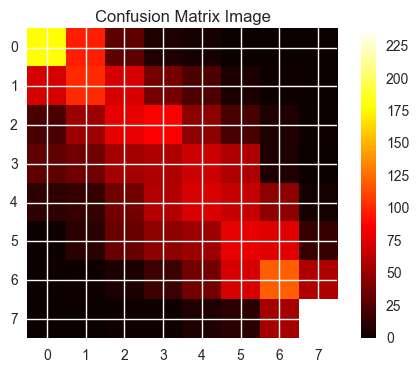

In [53]:
val_exp_pred = np.exp(val_predictions)

for bin_num in [4,8]:
    val_pred_bins = binning(val_exp_pred, bin_num)

    linr_val_set_bin_labels = binning(linr_likes[train_len:], bin_num)

    acc = metrics.precision_score(linr_val_set_bin_labels.values, val_pred_bins, average='macro')
    print "Linear Regression test precision fot %d bins: %f" %(bin_num, acc)

    m = confusion_matrix(linr_val_set_bin_labels.values, val_pred_bins)
    print m
    plotConfusion(m, bin_num)

## Lasso Regression

In [30]:
logr_pp_data = pp_data.copy()

logr_labels = logr_pp_data['likes'].apply(lambda x: np.log(x) if x > 0 else 0)
logr_ids = logr_pp_data['id']


######
logr_bin_labels = logr_pp_data['labels'].copy()
logr_train_set_bin_labels = logr_bin_labels[:train_len]
logr_val_set_bin_labels = logr_bin_labels[train_len:]
logr_likes = logr_pp_data['likes'].copy()
#####

logr_pp_data.drop(['likes', 'labels', 'id'], 1, inplace=True)


logr_data = preprocessing.minmax_scale(logr_pp_data) #TODO: remove this!

logr_train_set = logr_data[:train_len].copy()
logr_val_set = logr_data[train_len:].copy()

logr_train_labels = logr_labels[:train_len].copy()
logr_val_labels = logr_labels[train_len:].copy()

logr_train_ids = logr_ids[:train_len].copy()
logr_val_ids = logr_ids[train_len:].copy()

Computing regularization path using the coordinate descent lasso...


(0.36619945026772688,
 3.366199450267727,
 0.65236349148256845,
 16.107596035773806)

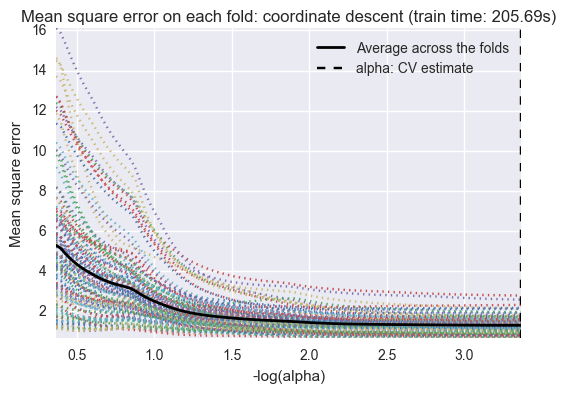

In [54]:
import time
# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
# Display results
logr = lm.LassoCV(cv=120)
logr.fit(logr_train_set, logr_train_labels)
m_log_alphas = -np.log10(logr.alphas_)
t_lasso_cv = time.time() - t1


plt.figure()
# ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, logr.mse_path_, ':')
plt.plot(m_log_alphas, logr.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(logr.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
# plt.ylim(ymin, ymax)


In [55]:
print "getting lasso regression predictions"
logr_train_predictions = logr.predict(logr_train_set)
logr_val_predictions = logr.predict(logr_val_set)

# The mean squared error
print "\n\nMean squared error: %.2f" %(np.mean((logr_train_predictions - logr_train_labels) ** 2))
# Explained variance score: 1 is perfect prediction
print 'training variance score: %.2f' %(logr.score(logr_train_set, logr_train_labels))
print 'test variance score: %.2f' %(logr.score(logr_val_set, logr_val_labels))

print "\n\ncalculating lasso regression Performance on the test set:"
print "train %f" %logr.score(logr_train_set, logr_train_labels.values)
print "test %f" %logr.score(logr_val_set, logr_val_labels.values)

getting lasso regression predictions


Mean squared error: 1.25
training variance score: 0.76
test variance score: 0.69


calculating lasso regression Performance on the test set:
train 0.762180
test 0.687248


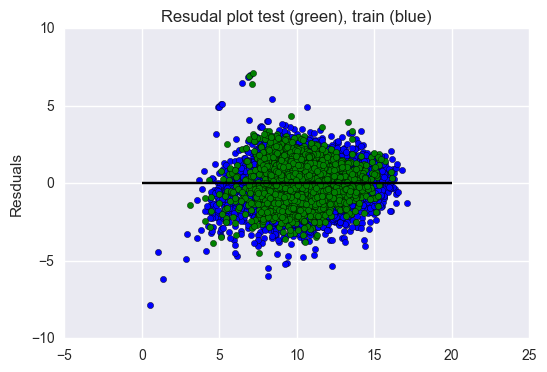

In [56]:
#TODO: add scatter plot predicted vs actual

plt.scatter(logr_train_predictions, logr_train_predictions -  logr_train_labels, c='b')#, s=40, alpha=0.6)
plt.scatter(logr_val_predictions, logr_val_predictions -  logr_val_labels, c='g')#, alpha=0.6)
plt.hlines(y=0, xmin=0, xmax=20)
plt.title('Resudal plot test (green), train (blue)')
plt.ylabel('Resduals')
plt.show()

Lasso train precision fot 4 bins: 0.634794
[[1905  594   53    1]
 [ 538 1250  715   50]
 [ 101  618 1329  504]
 [   9   91  455 1998]]


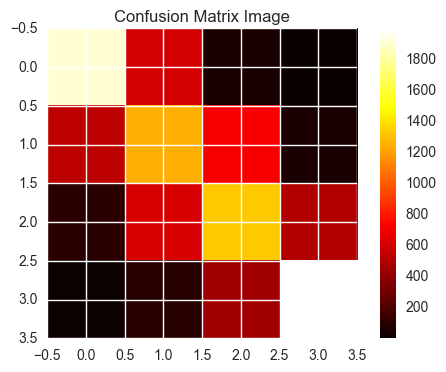

Lasso train precision fot 8 bins: 0.410497
[[859 317  74  22   4   1   0   0]
 [285 444 343 155  39   9   1   0]
 [ 79 296 390 281 166  55   9   0]
 [ 32 131 247 332 324 170  38   3]
 [ 15  52 139 274 339 315 133   9]
 [  5  29  61 144 275 400 289  73]
 [  0   5  20  64 106 277 520 284]
 [  2   2   2   5  23  49 286 908]]


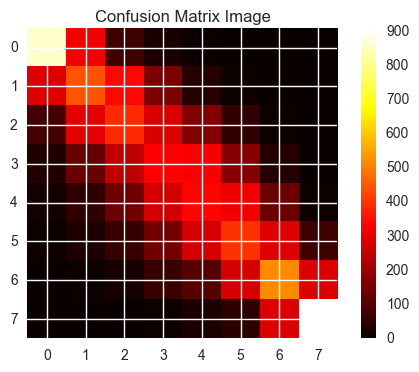

In [57]:
train_exp_pred = np.exp(logr_train_predictions)

for bin_num in [4,8]:
    train_pred_bins = binning(train_exp_pred, bin_num)

    logr_train_set_bin_labels = binning(logr_likes[:train_len], bin_num)

    acc = metrics.precision_score(logr_train_set_bin_labels.values, train_pred_bins, average='macro')
    print "Lasso train precision fot %d bins: %f" %(bin_num, acc)

    m = confusion_matrix(logr_train_set_bin_labels.values, train_pred_bins)
    print m
    plotConfusion(m, bin_num)

Lasso test precision fot 4 bins: 0.579271
[[448 151  38   2]
 [145 280 195  18]
 [ 43 178 275 142]
 [  3  29 130 476]]


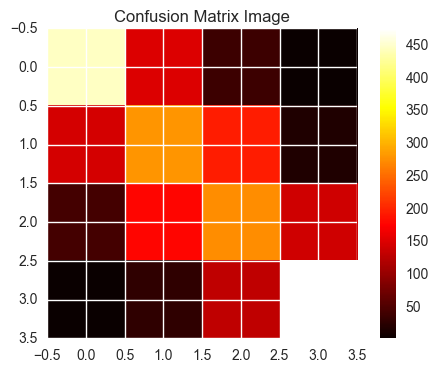

Lasso test precision fot 8 bins: 0.363024
[[180  93  34   9   4   0   0   0]
 [ 70 105  72  36  27   7   2   0]
 [ 22  55  78  91  42  22   8   1]
 [ 31  37  57  54  70  61   9   0]
 [ 14  15  38  62  72  68  46   4]
 [  2  12  32  46  57  78  76  16]
 [  1   2   6  19  38  71 122  60]
 [  0   0   2   2   9  12  56 238]]


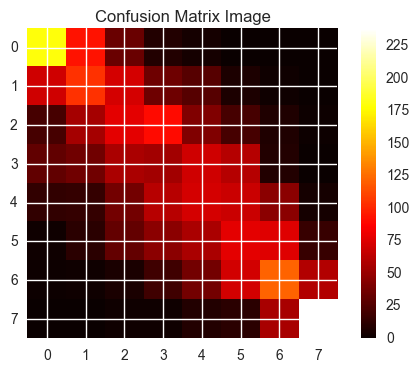

In [58]:
val_exp_pred = np.exp(logr_val_predictions)

for bin_num in [4,8]:
    val_pred_bins = binning(val_exp_pred, bin_num)

    logr_val_set_bin_labels = binning(logr_likes[train_len:], bin_num)

    acc = metrics.precision_score(logr_val_set_bin_labels.values, val_pred_bins, average='macro')
    print "Lasso test precision fot %d bins: %f" %(bin_num, acc)

    m = confusion_matrix(logr_val_set_bin_labels.values, val_pred_bins)
    print m
    plotConfusion(m, bin_num)